<a href="https://colab.research.google.com/github/guilhermefarias1995/Projetos-de-aprendizagem/blob/main/Metadados_SINDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTRODUÇÃO

## **O que é o SINDA?**  
O SINDA (Sistema Nacional de Dados Ambientais)** é uma infraestrutura de gerenciamento de dados ambientais coordenada pelo **INPE (Instituto Nacional de Pesquisas Espaciais)**, com o objetivo de:  

> *"Integrar, armazenar e disseminar dados ambientais provenientes de satélites, redes de observação terrestre e modelos numéricos, garantindo acesso público para aplicações em ciência, políticas públicas e tomada de decisão."*  
> **Fonte**: INPE (2023). Documentação Institucional do SINDA. Disponível em: [Portal do INPE](https://www.inpe.br).  
  ---

## **O que são Metadados no Contexto do SINDA?**  

Os **metadados do SINDA** representam um **conjunto estruturado de informações técnicas** sobre as **Plataformas de Coleta de Dados (PCDs)** e seus atributos, extraídos diretamente de um *dump* do banco de dados do sistema. Eles funcionam como:  

- **Identificadores técnicos**: Chaves únicas (ex.: número da PCD, código da estação, id do cliente).  
- **Localização espacial**: Coordenadas geográficas (latitude/longitude), cidade e estado onde estão localizadas as PCDs.  
- **Outras informaçoes relevantes**: Status da plataforma (ativa/inativa), descrição dos clientes, sensores disponíveis, tipos de sensores.  

Objetivo dos Metadados Neste Contexto:**  
 **Rastreabilidade**:  
   - Saber qual PCD gerou quais dados.  
   - Exemplo: Vincular a velocidade do vento a uma estação específica.  

**Controle de Qualidade**:  
   - Identificar PCDs inativas ou com sensores defeituosos
   - Verificar a consistência dos dados

**Contexto Espacial**:  
   - Agrupar dados por região (ex.: todas as PCDs no bacia Amazônica).  

---

#### **Por que Analisar os Metadados do SINDA?**  
A qualidade dos metadados impacta diretamente:  
- Dados com metadados incompletos são difíceis de localizar.  
- Metadados imprecisos levam a erros de interpretação.  

---

**Objetivo desta análise**:  
Identificar lacunas, inconsistências e oportunidades de melhoria nos metadados do SINDA, propondo ações para:  
- Aumentar a **completude** dos campos obrigatórios. (ex.:buscar mecanismo de preenchimento de dados faltosos)  
- Padronizar **formatos** (ex.: datas, unidades de medida, tipos de sensores).  
- Melhorar a **descrição** dos conjuntos de dados para se obter uma analise mais.  

---




#Importando os dados

## **Processo de Importação do Dump SQL do SINDA via Python**  

Para realizar a análise dos metadados do SINDA, foi necessário extrair os dados diretamente de um **dump em formato SQL**, contendo as tabelas do banco de dados.

---

## **Entendendo a Estrutura do Dump SQL**  
O arquivo fornecido (`spada-22052023.sql`) contém:  
- Definições de tabelas (CREATE TABLE).  
- Dados inseridos (INSERT INTO).
- Idetificar onde inicia o comando de criação de tabelas, quais são as tabelas presentes no Dump, quantidade de dados presntes em cada tabela e o processo de extração dos dados da tabela para um dataframe.  

---

##**Tabelas Principais Envolvidas**:  
- `pcd`: Informações das Plataformas de Coleta de Dados (ID, nome, status).  
- `cliente`: Contém informações dos dados dos clientes que são proprietarios das PCDs bem como algusn dos principais usuários dos dados.
- `sensores`: Tipos de sensores associados a cada PCD. (Temperatura, Pressão, Radiação Solar)  

---



In [145]:
import pandas as pd
"""
Inspecionar rapidamente o conteúdo de um dump SQL (exportação de banco de dados)
Verificar a estrutura do arquivo antes de processá-lo completamente
Checar se o arquivo foi aberto/carregado corretamente
"""

with open('/content/spada-22052023.sql', 'r', encoding='utf-8', errors='ignore') as f:
    primeiras_linhas = [next(f) for _ in range(20)]

print("=== PRIMEIRAS 20 LINHAS DO DUMP ===")
for i, linha in enumerate(primeiras_linhas, 1):
    print(f"{i}: {linha.strip()}")

=== PRIMEIRAS 20 LINHAS DO DUMP ===
1: --
2: -- PostgreSQL database dump
3: --
4: 
5: -- Dumped from database version 9.6.2
6: -- Dumped by pg_dump version 9.6.2
7: 
8: SET statement_timeout = 0;
9: SET lock_timeout = 0;
10: SET idle_in_transaction_session_timeout = 0;
11: SET client_encoding = 'UTF8';
12: SET standard_conforming_strings = on;
13: SET check_function_bodies = false;
14: SET client_min_messages = warning;
15: SET row_security = off;
16: 
17: --
18: -- Name: spada; Type: SCHEMA; Schema: -; Owner: -
19: --
20: 


In [146]:
!pip install pandas geopy

#instalando as extensões necessárias

In [147]:
!pip install geodatasets

In [148]:
!pip install geodatasets

In [149]:
!pip install --upgrade geopandas geodatasets plotly

In [150]:
!pip install geopandas folium matplotlib

In [151]:
!pip install --upgrade pandas

#Analise do dump do banco de dados SPADA


In [152]:
"""
Identificar rapidamente onde começam os comandos de inserção de dados em um dump SQL
Verificar a estrutura do arquivo antes de importá-lo para um banco de dados
Encontrar a posição exata onde os dados reais começam (após possíveis definições de schema)
"""

with open('/content/spada-22052023.sql', 'r') as f:
    for i, linha in enumerate(f, 1):
        if 'COPY ' in linha or 'INSERT INTO' in linha:
            print(f"Linha {i}: {linha.strip()}")
            break

Linha 537: COPY schema_version (installed_rank, version, description, type, script, checksum, installed_by, installed_on, execution_time, success) FROM stdin;


In [153]:
#identificar todas as tabelas
import re

def listar_tabelas(dump_path):
    with open(dump_path, 'r', encoding='utf-8', errors='ignore') as f:
        dump = f.read()

    # Padrão para encontrar tabelas (considera COPY e CREATE TABLE)
    tabelas_copy = set(re.findall(
        r"COPY\s+(?:public\.)?(\w+)\s*\(.*?\)\s*FROM\s+stdin;",
        dump, re.IGNORECASE
    ))

    tabelas_create = set(re.findall(
        r"CREATE\s+TABLE\s+(?:public\.)?(\w+)",
        dump, re.IGNORECASE
    ))

    # Combina os resultados e remove duplicatas
    todas_tabelas = sorted(tabelas_copy.union(tabelas_create))

    return todas_tabelas

# Uso:
tabelas = listar_tabelas('/content/spada-22052023.sql')
print("Tabelas encontradas no dump:")
for i, tabela in enumerate(tabelas, 1):
    print(f"{i}. {tabela}")

Tabelas encontradas no dump:
1. cliente
2. decodificador
3. estacao
4. evento_sistema
5. evento_ultima_atualizacao_dados_pcd
6. familia_pcd
7. familia_pcd_aud
8. fluxo_processamento
9. historico_envio_dados_pcd_cliente
10. mapeamento_pcd_28_bits
11. parametro_sistema
12. parametro_sistema_aud
13. pcd
14. pcd_aud
15. pcd_interesse_cliente
16. pcd_periodo_com_dado
17. quadro
18. quadro_aud
19. recuperar_senha_usuario
20. reprocessamento_pcd_realizado
21. revisao_auditoria
22. satelite
23. schema_version
24. sensor
25. sensor_aud
26. servidor
27. usuario


In [154]:
import os
print("Arquivo existe?", os.path.exists('/content/spada-22052023.sql'))
print("Tamanho:", os.path.getsize('/content/spada-22052023.sql'), "bytes")

Arquivo existe? True
Tamanho: 4988917 bytes


In [155]:
def analisar_formato_dados(dump_path):
    """Analisa o formato real dos dados no arquivo"""
    print("\n🔍 Análise detalhada do formato:")

    with open(dump_path, 'r', encoding='utf-8') as f:
        for line in f:
            if 'COPY ' in line and ' FROM stdin;' in line:
                tabela = line.split('COPY ')[1].split(' FROM ')[0].split('(')[0].strip()
                print(f"\nTabela: {tabela}")
                print(f"Estrutura: {line.strip()}")

                # Mostra as primeiras linhas de dados
                print("\nPrimeiros dados:")
                for _ in range(3):
                    data_line = next(f).strip()
                    if data_line == '\.':
                        break
                    print(f"→ {data_line}")

                # Verifica separador
                next_line = next(f).strip()
                if next_line != '\.':
                    sep = 'TAB' if '\t' in next_line else 'VÍRGULA'
                    print(f"Separador detectado: {sep}")
                break

analisar_formato_dados('/content/spada-22052023.sql')


🔍 Análise detalhada do formato:

Tabela: schema_version
Estrutura: COPY schema_version (installed_rank, version, description, type, script, checksum, installed_by, installed_on, execution_time, success) FROM stdin;

Primeiros dados:
→ 1	1	Setup inicial banco estrutura	SQL	V1__Setup_inicial_banco_estrutura.sql	1645569788	postgres	2017-09-08 17:13:46.899532	263	t
→ 2	1.1	Criado tebela recuperar senha usuario	SQL	V1_1__Criado_tebela_recuperar_senha_usuario.sql	453806584	postgres	2017-09-08 17:13:47.184548	6	t
→ 3	1.2	Correcoes no banco	SQL	V1_2__Correcoes_no_banco.sql	1781767543	postgres	2017-09-08 17:13:47.212549	68	t
Separador detectado: TAB


#Extraindo todas as tabelas do dump
Aqui iremos extrair todas as tabelas do dump e salav-las em um data frame

In [156]:
import pandas as pd
import numpy as np
from datetime import datetime

def parse_postgresql_dump(dump_path):
    """
    Extrai todas as tabelas de um dump PostgreSQL, convertendo tipos automaticamente
    Retorna um dicionário de DataFrames e cria variáveis globais df_[nome_tabela]
    """
    # Dicionário para armazenar os DataFrames
    tabelas = {}

    # Variáveis de controle
    current_table = None
    current_columns = None
    current_data = []

    with open(dump_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            # 1. Detecta início da tabela
            if line.startswith('COPY ') and ' FROM stdin;' in line:
                parts = line.split('COPY ')[1].split(' FROM ')[0].split('(')
                current_table = parts[0].strip()
                current_columns = [col.strip().strip('"') for col in parts[1].split(')')[0].split(',')]
                current_data = []
                continue

            # 2. Processa dados (separados por TAB)
            if current_table:
                if line == '\.':
                    # Final da tabela - cria o DataFrame
                    if current_data:
                        df = pd.DataFrame(current_data, columns=current_columns)
                        df = converter_tipos_postgres(df)
                        tabelas[f'df_{current_table}'] = df
                        print(f"✅ {current_table}: {len(df)} registros")
                    current_table = None
                    continue

                if line and not line.startswith('\\'):
                    current_data.append(line.split('\t'))

    # Cria variáveis globais
    globals().update(tabelas)
    return tabelas

def converter_tipos_postgres(df):
    """Conversão específica para tipos PostgreSQL"""
    for col in df.columns:
        # Booleanos (PostgreSQL usa 't'/'f')
        if df[col].isin(['t', 'f']).all():
            df[col] = df[col] == 't'
            continue

        # Datas e timestamps
        try:
            df[col] = pd.to_datetime(df[col], erros='coerce')
            continue
        except:
            pass

        # Números inteiros
        try:
            if df[col].astype(float).eq(df[col].astype(float).round()).all():
                df[col] = pd.to_numeric(df[col], downcast='integer')
                continue
        except:
            pass

        # Números decimais
        try:
            df[col] = pd.to_numeric(df[col])
            continue
        except:
            pass

        # Strings (remove espaços extras)
        try:
            df[col] = df[col].str.strip()
        except:
            pass

    return df

# Uso:
todos_dfs = parse_postgresql_dump('/content/spada-22052023.sql')
#total de dados no banco
total_registros = sum(len(df) for df in todos_dfs.values())
print(f"Total de registros: {total_registros}")

✅ schema_version: 25 registros
✅ cliente: 80 registros
✅ decodificador: 2 registros
✅ estacao: 4 registros
✅ evento_sistema: 2468 registros
✅ evento_ultima_atualizacao_dados_pcd: 600 registros
✅ familia_pcd: 131 registros
✅ fluxo_processamento: 2 registros
✅ mapeamento_pcd_28_bits: 62 registros
✅ parametro_sistema: 1 registros
✅ pcd: 1194 registros
✅ pcd_interesse_cliente: 5501 registros
✅ pcd_periodo_com_dado: 1052 registros
✅ quadro: 2 registros
✅ recuperar_senha_usuario: 5 registros
✅ reprocessamento_pcd_realizado: 32 registros
✅ satelite: 9 registros
✅ sensor: 3416 registros
✅ servidor: 80 registros
✅ usuario: 10 registros
✅ familia_pcd_aud: 1261 registros
✅ parametro_sistema_aud: 1 registros
✅ pcd_aud: 1247 registros
✅ quadro_aud: 2 registros
✅ revisao_auditoria: 1346 registros
✅ sensor_aud: 28501 registros
Total de registros: 47034


In [157]:
#listagem de todos os Dataframes presentes no banco.
todos_dfs

{'df_schema_version':     installed_rank  version  \
 0                1      1.0   
 1                2      1.1   
 2                3      1.2   
 3                4      1.3   
 4                5      1.4   
 5                6      1.5   
 6                7      1.6   
 7                8      1.7   
 8                9      1.8   
 9               10      1.9   
 10              11      2.0   
 11              12      2.1   
 12              13      2.2   
 13              14      2.3   
 14              15      2.4   
 15              16      2.5   
 16              17      2.6   
 17              18      2.7   
 18              19      2.8   
 19              20      2.9   
 20              21      3.0   
 21              22      3.1   
 22              23      3.2   
 23              24      3.3   
 24              25      3.4   
 
                                           description type  \
 0                       Setup inicial banco estrutura  SQL   
 1               Cr

In [158]:
todos_dfs

{'df_schema_version':     installed_rank  version  \
 0                1      1.0   
 1                2      1.1   
 2                3      1.2   
 3                4      1.3   
 4                5      1.4   
 5                6      1.5   
 6                7      1.6   
 7                8      1.7   
 8                9      1.8   
 9               10      1.9   
 10              11      2.0   
 11              12      2.1   
 12              13      2.2   
 13              14      2.3   
 14              15      2.4   
 15              16      2.5   
 16              17      2.6   
 17              18      2.7   
 18              19      2.8   
 19              20      2.9   
 20              21      3.0   
 21              22      3.1   
 22              23      3.2   
 23              24      3.3   
 24              25      3.4   
 
                                           description type  \
 0                       Setup inicial banco estrutura  SQL   
 1               Cr

#Bibliotecas Utilizadas


In [159]:
#limpar df
def limpar_df(df):
    for col in df.columns:
        df[col] = df[col].replace('\\N', None)
    return df
df_cliente = limpar_df(df_cliente)

#Inicio da Analise Exploratoria

---



---



##Explorando a tabela cliente

In [160]:
df_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id                                         80 non-null     int32 
 1   ativo                                      80 non-null     bool  
 2   cep                                        4 non-null      object
 3   cidade                                     4 non-null      object
 4   companhia_orgao                            79 non-null     object
 5   departamento_secao                         6 non-null      object
 6   email                                      4 non-null      object
 7   estado                                     3 non-null      object
 8   fax                                        4 non-null      object
 9   logradouro                                 4 non-null      object
 10  nome                                    

In [161]:
df_cliente.head(80)

id  ativo         cep              cidade  \
0   141145   True        None                None   
1   142725   True        None                None   
2     1080   True   59064-000               Natal   
3   134545   True        None                None   
4   134546   True        None                None   
..     ...    ...         ...                 ...   
75  134579   True        None                None   
76    1038   True  indefinido          indefinido   
77    1015   True         xxx  Cachoeria Paulista   
78     105   True        None                None   
79      58   True        None                None   

                                      companhia_orgao  \
0                                      INPE-CRN-NATAL   
1                                                None   
2                                        INPE - Natal   
3        ADA - Agencia de Desenvolvimento da Amazônia   
4   Agência Executiva de Gestão das Águas do Estad...   
..                                                ...   
75  Instituto de Meio Ambiente e Recursos Hídricos...   
76             Empresa de Pesquisa Agropecuária do RN   
77                               INPE - Laboratorio I   
78                     ALCOA WORD ALUNINA BRASIL LTDA   
79                    Centro de Hidrologia da Marinha   

                                   departamento_secao                email  \
0                                               LAVAT                 None   
1                                                None                 None   
2                                       Secao Tecnica  kennedy@crn.inpe.br   
3                                                None                 None   
4                                                None                 None   
..                                                ...                  ...   
75  COMON - Coordenação de Monitoramento de Recurs...                 None   
76                                         indefinido           indefinido   
77                                                                     xxx   
78                                               None                 None   
79                                               None                 None   

   estado            fax                       logradouro     nome  \
0    None           None                             None    Lavat   
1    None           None                             None     ufma   
2      RN  (084)231-4941  Av.Senador Salgado Filho - 3000      crn   
3    None           None                             None   adamaz   
4    None           None                             None     aesa   
..    ...            ...                              ...      ...   
75   None           None                             None    inema   
76   None     indefinido                       indefinido   emparn   
77     SP            xxx                                       lim   
78   None           None                             None    alcoa   
79   None           None                             None  dhnboia   

          pais           responsavel       telefone  \
0         None    Francisco Raimundo           None   
1         None                  None           None   
2       Barsil  Kennedy Dantas Rocha  (084)231-4733   
3         None                  None           None   
4         None                  None           None   
..         ...                   ...            ...   
75        None                  None           None   
76  indefinido            indefinido     indefinido   
77      Braisl                                  xxx   
78        None                  None           None   
79        None                  None           None   

   id_servidor_saida_dados_decodificados  \
0                                   None   
1                                 142733   
2                                  39861   
3                                 134470   
4                          

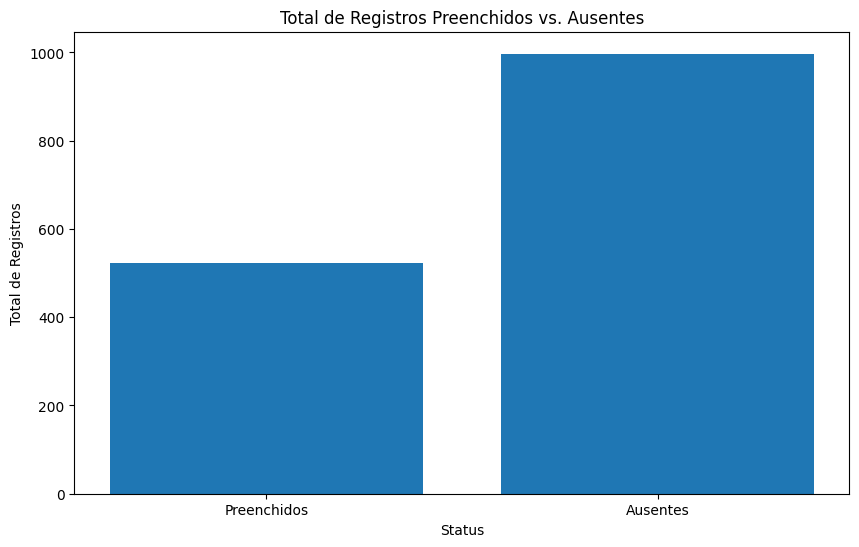

In [162]:
#grafico de total de dados ausentes em relacao aos preenchidos da tabela cliente
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(['Preenchidos', 'Ausentes'], [df_cliente.notnull().sum().sum(), df_cliente.isnull().sum().sum()])
plt.xlabel('Status')
plt.ylabel('Total de Registros')
plt.title('Total de Registros Preenchidos vs. Ausentes')
plt.show()


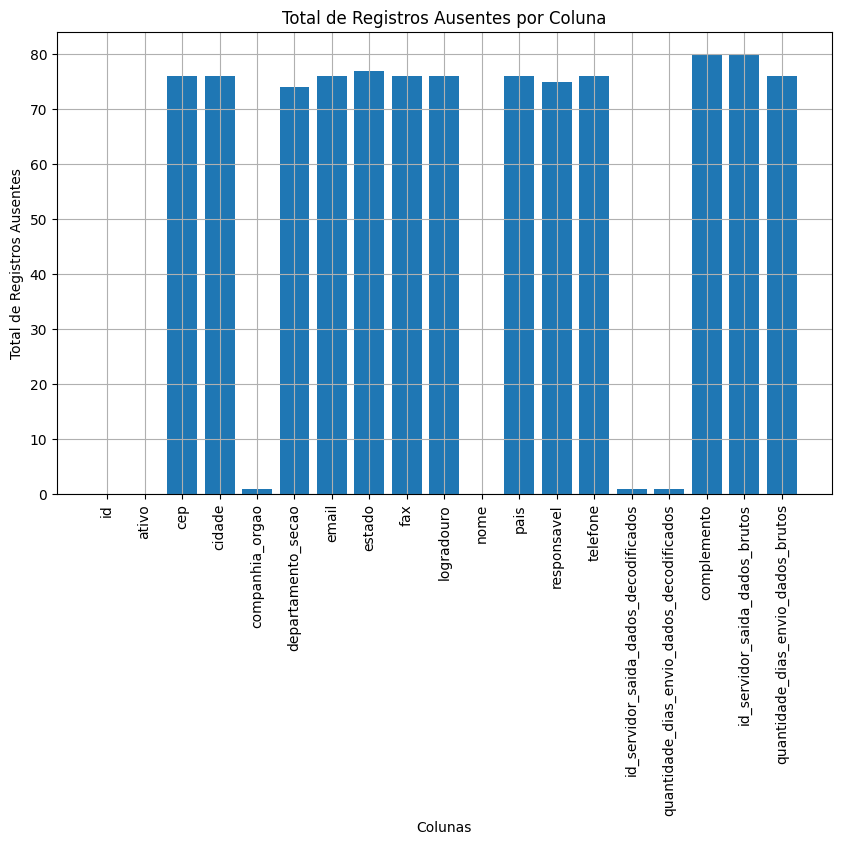

In [163]:
#visulizando graficamente colunas da tabela cliente com mais dados ausentes
plt.figure(figsize=(10, 6))
plt.bar(df_cliente.columns, df_cliente.isnull().sum())
plt.xlabel('Colunas')
plt.ylabel('Total de Registros Ausentes')
plt.title('Total de Registros Ausentes por Coluna')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [164]:
import pandas as pd
import requests
from time import sleep
import re

# Base de conhecimento ampliada com país
BASE_ORGAOS = {
    'INPE': {'cep': '12227-010', 'cidade': 'São José dos Campos', 'estado': 'SP', 'pais': 'Brasil'},
    'EMBRAPA': {'cep': '70770-901', 'cidade': 'Brasília', 'estado': 'DF', 'pais': 'Brasil'},
    'CEMIG': {'cep': '30190-921', 'cidade': 'Belo Horizonte', 'estado': 'MG', 'pais': 'Brasil'},
    'ANA': {'cep': '70610-200', 'cidade': 'Brasília', 'estado': 'DF', 'pais': 'Brasil'},
    'CPTEC': {'cep': '12630-000', 'cidade': 'Cachoeira Paulista', 'estado': 'SP', 'pais': 'Brasil'},
    'UFAM': {'cep': '69067-005', 'cidade': 'Manaus', 'estado': 'AM', 'pais': 'Brasil'},
    'UFT': {'cep': '77020-122', 'cidade': 'Palmas', 'estado': 'TO', 'pais': 'Brasil'},
    'UNICAMP': {'cep': '13083-970', 'cidade': 'Campinas', 'estado': 'SP', 'pais': 'Brasil'},
    'FUNDAÇÃO OSWALDO CRUZ': {'cep': '21040-360', 'cidade': 'Rio de Janeiro', 'estado': 'RJ', 'pais': 'Brasil'},
    'ITEP': {'cep': '50761-001', 'cidade': 'Recife', 'estado': 'PE', 'pais': 'Brasil'},
    'IBAMA': {'cep': '70818-900', 'cidade': 'Brasília', 'estado': 'DF', 'pais': 'Brasil'},
    'SABESP': {'cep': '01228-000', 'cidade': 'São Paulo', 'estado': 'SP', 'pais': 'Brasil'},
    'BOLIVIA': {'pais': 'Bolívia'},  # Padrão para casos na Bolívia
    'DADOS BOLIVIA': {'pais': 'Bolívia'}
}

def normalizar_nome(texto):
    """Normaliza o texto para comparação"""
    if pd.isna(texto):
        return ""
    texto = str(texto).strip().upper()
    texto = re.sub(r'[^A-ZÀ-Ú\s]', '', texto)
    return ' '.join(texto.split())

def identificar_pais(nome_orgao):
    """Identifica o país com base em palavras-chave no nome"""
    nome_normalizado = normalizar_nome(nome_orgao)

    # Palavras-chave que indicam Bolívia
    palavras_bolivia = ['BOLIVIA', 'BOLÍVIA', 'BOLIVIAN']
    if any(palavra in nome_normalizado for palavra in palavras_bolivia):
        return {'pais': 'Bolívia'}

    return {'pais': 'Brasil'}  # Default para Brasil

def buscar_info_orgao(nome_orgao):
    """
    Busca informações do órgão na base local e APIs externas
    Retorna um dicionário com: cep, cidade, estado, pais
    """
    nome_normalizado = normalizar_nome(nome_orgao)

    # 1. Verifica se é um caso da Bolívia
    info_pais = identificar_pais(nome_orgao)
    if info_pais['pais'] == 'Bolívia':
        return info_pais

    # 2. Verifica na base local
    for orgao, info in BASE_ORGAOS.items():
        if orgao in nome_normalizado:
            return {**info, **info_pais}  # Combina com info do país

    # 3. Busca em API genérica (Nominatim)
    try:
        url = f"https://nominatim.openstreetmap.org/search?q={nome_normalizado.replace(' ', '+')}&format=json&addressdetails=1&limit=1&countrycodes=br"
        headers = {'User-Agent': 'Mozilla/5.0'}

        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            data = response.json()
            if data:
                address = data[0].get('address', {})
                return {
                    'cep': address.get('postcode'),
                    'cidade': address.get('city') or address.get('town') or address.get('village'),
                    'estado': address.get('state'),
                    'pais': address.get('country', 'Brasil')
                }
    except Exception as e:
        print(f"Erro na API: {e}")

    # Retorna pelo menos o país padrão
    return info_pais

def imputar_dados_orgao(df, coluna_orgao='companhia_orgao'):
    """
    Imputa CEP, cidade, estado e país com base no nome do órgão

    Args:
        df (pd.DataFrame): DataFrame de entrada
        coluna_orgao (str): Nome da coluna com os nomes dos órgãos

    Returns:
        pd.DataFrame: DataFrame com os dados imputados
    """
    df = df.copy()
    total = len(df)
    stats = {'sucessos': 0, 'pais_imputado': 0}

    for idx, row in df.iterrows():
        nome_orgao = row[coluna_orgao]
        print(f"Processando {idx+1}/{total}: {nome_orgao}")

        info = buscar_info_orgao(nome_orgao)

        if info:
            # Para cada campo, verifica se precisa imputar
            campos = ['cep', 'cidade', 'estado', 'pais']
            for campo in campos:
                if campo in info and (pd.isna(row[campo]) or str(row[campo]) in ['', '\\N']):
                    df.at[idx, campo] = info[campo]
                    if campo == 'pais':
                        stats['pais_imputado'] += 1

            stats['sucessos'] += 1
            print(f"✅ Dados encontrados: { {k: v for k, v in info.items() if v} }")
        else:
            print("❌ Dados não encontrados")

        sleep(1)  # Respeita limite de requisições

    print(f"\nResumo:")
    print(f"- Dados imputados em {stats['sucessos']} de {total} registros")
    print(f"- País imputado em {stats['pais_imputado']} registros")
    return df

In [165]:
df_cliente = imputar_dados_orgao(df_cliente)

Processando 1/80: INPE-CRN-NATAL
✅ Dados encontrados: {'cep': '12227-010', 'cidade': 'São José dos Campos', 'estado': 'SP', 'pais': 'Brasil'}
Processando 2/80: None
✅ Dados encontrados: {'pais': 'Brasil'}
Processando 3/80: INPE - Natal
✅ Dados encontrados: {'cep': '12227-010', 'cidade': 'São José dos Campos', 'estado': 'SP', 'pais': 'Brasil'}
Processando 4/80: ADA - Agencia de Desenvolvimento da Amazônia
✅ Dados encontrados: {'pais': 'Brasil'}
Processando 5/80: Agência Executiva de Gestão das Águas do Estado da Paraíba
✅ Dados encontrados: {'pais': 'Brasil'}
Processando 6/80: Agencia Nacional de Energia Eletricas
✅ Dados encontrados: {'pais': 'Brasil'}
Processando 7/80: Agencia Nacional de Energia Eletricas
✅ Dados encontrados: {'pais': 'Brasil'}
Processando 8/80: Agência Pernambucana de Águas e Clima
✅ Dados encontrados: {'cep': '70610-200', 'cidade': 'Brasília', 'estado': 'DF', 'pais': 'Brasil'}
Processando 9/80: Dados da Bolivia
✅ Dados encontrados: {'pais': 'Bolívia'}
Processando 1

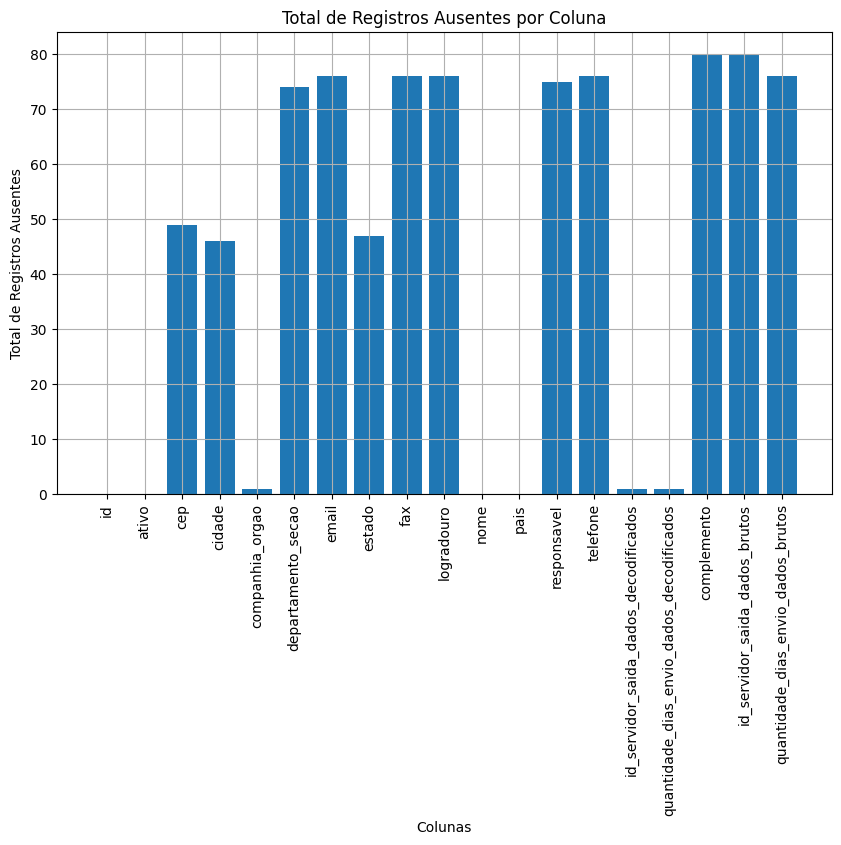

In [166]:
#visuliza em grafico de barras colunas ausentes apos analise
plt.figure(figsize=(10, 6))
plt.bar(df_cliente.columns, df_cliente.isnull().sum())
plt.xlabel('Colunas')
plt.ylabel('Total de Registros Ausentes')
plt.title('Total de Registros Ausentes por Coluna')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

###funcao para limpeza basica do dataset

In [167]:
#visualizar duas colunas compnhia e nome e id
df_cliente[['companhia_orgao', 'nome','id', 'cep', 'cidade']]


companhia_orgao     nome      id  \
0                                      INPE-CRN-NATAL    Lavat  141145   
1                                                None     ufma  142725   
2                                        INPE - Natal      crn    1080   
3        ADA - Agencia de Desenvolvimento da Amazônia   adamaz  134545   
4   Agência Executiva de Gestão das Águas do Estad...     aesa  134546   
..                                                ...      ...     ...   
75  Instituto de Meio Ambiente e Recursos Hídricos...    inema  134579   
76             Empresa de Pesquisa Agropecuária do RN   emparn    1038   
77                               INPE - Laboratorio I      lim    1015   
78                     ALCOA WORD ALUNINA BRASIL LTDA    alcoa     105   
79                    Centro de Hidrologia da Marinha  dhnboia      58   

           cep               cidade  
0    12227-010  São José dos Campos  
1         None                 None  
2    59064-000                Natal  
3         None                 None  
4         None                 None  
..         ...                  ...  
75        None                 None  
76  indefinido           indefinido  
77         xxx   Cachoeria Paulista  
78        None                 None  
79        None                 None  

[80 rows x 5 columns]

##Explorando outros Data frames

In [168]:
df_familia_pcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             131 non-null    int32 
 1   ativo          131 non-null    bool  
 2   nome           131 non-null    object
 3   data_cadastro  131 non-null    object
 4   tipo_pcd       131 non-null    object
dtypes: bool(1), int32(1), object(3)
memory usage: 3.8+ KB


In [169]:
limpar_df(df_familia_pcd)
df_familia_pcd.head()

id  ativo                                         nome  \
0  1100   True                                        30800   
1  1105   True                       Familia - 30866, 32143   
2  1111   True  Familia - 30872, 30874, 30867, 30869, 30870   
3  1112   True                       Familia - 30873, 30871   
4  1114   True         Familia - 30875, 30876, 30877, 30878   

             data_cadastro   tipo_pcd  
0  2017-09-08 17:24:27.607  UM_QUADRO  
1  2017-09-08 17:24:27.607  UM_QUADRO  
2  2017-09-08 17:24:27.607  UM_QUADRO  
3  2017-09-08 17:24:27.607  UM_QUADRO  
4  2017-09-08 17:24:27.607  UM_QUADRO

In [170]:
limpar_df(df_fluxo_processamento)
df_fluxo_processamento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                2 non-null      int32 
 1   ativo             2 non-null      bool  
 2   habilitado        2 non-null      bool  
 3   nome              2 non-null      object
 4   id_decodificador  2 non-null      int8  
 5   id_servidor       2 non-null      int32 
dtypes: bool(2), int32(2), int8(1), object(1)
memory usage: 170.0+ bytes


In [171]:
limpar_df(df_mapeamento_pcd_28_bits)
df_mapeamento_pcd_28_bits.head()

id ativo   base  id_pcd_20_bits
0  46  None  43616            2033
1  47  None  69000            7243
2  48  None  69024            7249
3  49  None  69040            7250
4  50  None  69056            7251


##Explorando a tabela PCD e PCD_aud


In [172]:
df_pcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          1194 non-null   int32 
 1   ativo                       1194 non-null   bool  
 2   altitude                    1194 non-null   object
 3   canais                      1194 non-null   object
 4   codigo_wmo_flu              1194 non-null   object
 5   estado                      1194 non-null   object
 6   fabricante                  1194 non-null   object
 7   habilitado                  1194 non-null   bool  
 8   intervalo_tempo_coleta      1194 non-null   object
 9   latitude                    1194 non-null   object
 10  cidade                      1194 non-null   object
 11  longitude                   1194 non-null   object
 12  modelo                      1194 non-null   object
 13  numero                      1194 non-null   int3

In [173]:
df_pcd_aud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          1247 non-null   int32 
 1   rev                         1247 non-null   int32 
 2   revtype                     1247 non-null   int8  
 3   ativo                       1247 non-null   bool  
 4   data_cadastro               1247 non-null   object
 5   identidicador_nome_arquivo  1247 non-null   object
 6   altitude                    1247 non-null   object
 7   canais                      1247 non-null   object
 8   codigo_wmo_flu              1247 non-null   object
 9   estado                      1247 non-null   object
 10  fabricante                  1247 non-null   object
 11  habilitado                  1247 non-null   bool  
 12  intervalo_tempo_coleta      1247 non-null   object
 13  latitude                    1247 non-null   obje

In [174]:
limpar_df(df_pcd_aud)
limpar_df(df_pcd)

id  ativo     altitude canais codigo_wmo_flu   estado fabricante  \
0       3166   True   667.000000      2              0       BA     HANDAR   
1       2250   True  1048.000000      1              1       DF          H   
2     141295   True         None   None           None       RN       None   
3     141557  False    52.000000   None              1       RN        BKS   
4       2288   True   586.000000      1          e2e21       PA   Squitter   
...      ...    ...          ...    ...            ...      ...        ...   
1189    3179   True         None      2                 Bolivia     HANDAR   
1190    3157   True   517.000000      1              1       SP     HANDAR   
1191    2622   True    62.000000      2              0       MA     HANDAR   
1192    2331   True    87.000000      1              1       RN          h   
1193   82397   True    87.000000   None              1       RN       None   

      habilitado intervalo_tempo_coleta  latitude  ... numero  \
0           True               10800000   -13.571  ...  32548   
1           True                3600000      None  ...  30866   
2           True                   None    -5.487  ...  70113   
3           True                   None    -6.066  ...  70116   
4           True                3600000      None  ...  30904   
...          ...                    ...       ...  ...    ...   
1189        True               10800000   -16.822  ...  32561   
1190        True                3600000   -22.588  ...  32539   
1191        True               10800000    -2.590  ...  32003   
1192        True                  60000    -5.835  ...  31046   
1193        True                3600000  -5.835\n  ...  31050   

     outras_informacoes potencia  versao_software id_proprietario  \
0          Meteorologia        1            BRNM6            1015   
1           hidrologica        1               QA            1015   
2                  None     None             None          141145   
3                  None        1             None            1080   
4           Hidrologica        1            ELNH4            1015   
...                 ...      ...              ...             ...   
1189       Meteorologia        1             BRM4            1015   
1190              Qagua        1        QA-120506            1015   
1191       Meteorologia        1            BRNM5            1015   
1192      Meteorologica        1                h            1080   
1193               None        1             None            1080   

                data_cadastro identidicador_nome_arquivo    pais  \
0     2017-09-08 17:24:27.607                       None    None   
1     2017-09-08 17:24:27.607                       None    None   
2     2019-06-10 14:10:13.217                       None    None   
3      2019-07-31 15:30:29.76                       None  Brasil   
4     2017-09-08 17:24:27.607                       None    None   
...                       ...                        ...     ...   
1189  2017-09-08 17:24:27.607                       None    None   
1190  2017-09-08 17:24:27.607                       None    None   
1191  2017-09-08 17:24:27.607                       None    None   
1192  2017-09-08 17:24:27.607                       None    None   
1193  2017-09-19 15:06:50.911                       None  Brasil   

     id_familia_pcd            estacao  
0              1997         Jaguaquara  
1              1105               None  
2                73       Maxaranguape  
3            141544       Monte Alegre  
4              1143               None  
...             ...                ...  
1189           2042  Puerto Villarroel  
1190          94080           Cruzeiro  
1191           1144           Sao Luis  
1192           1186        Sinalizador  
1193          82382              Teste  

[1194 rows x 23 columns]

In [175]:
df_pcd.head()

id  ativo     altitude canais codigo_wmo_flu estado fabricante  \
0    3166   True   667.000000      2              0     BA     HANDAR   
1    2250   True  1048.000000      1              1     DF          H   
2  141295   True         None   None           None     RN       None   
3  141557  False    52.000000   None              1     RN        BKS   
4    2288   True   586.000000      1          e2e21     PA   Squitter   

   habilitado intervalo_tempo_coleta latitude  ... numero outras_informacoes  \
0        True               10800000  -13.571  ...  32548       Meteorologia   
1        True                3600000     None  ...  30866        hidrologica   
2        True                   None   -5.487  ...  70113               None   
3        True                   None   -6.066  ...  70116               None   
4        True                3600000     None  ...  30904        Hidrologica   

  potencia  versao_software id_proprietario            data_cadastro  \
0        1            BRNM6            1015  2017-09-08 17:24:27.607   
1        1               QA            1015  2017-09-08 17:24:27.607   
2     None             None          141145  2019-06-10 14:10:13.217   
3        1             None            1080   2019-07-31 15:30:29.76   
4        1            ELNH4            1015  2017-09-08 17:24:27.607   

  identidicador_nome_arquivo    pais id_familia_pcd       estacao  
0                       None    None           1997    Jaguaquara  
1                       None    None           1105          None  
2                       None    None             73  Maxaranguape  
3                       None  Brasil         141544  Monte Alegre  
4                       None    None           1143          None  

[5 rows x 23 columns]

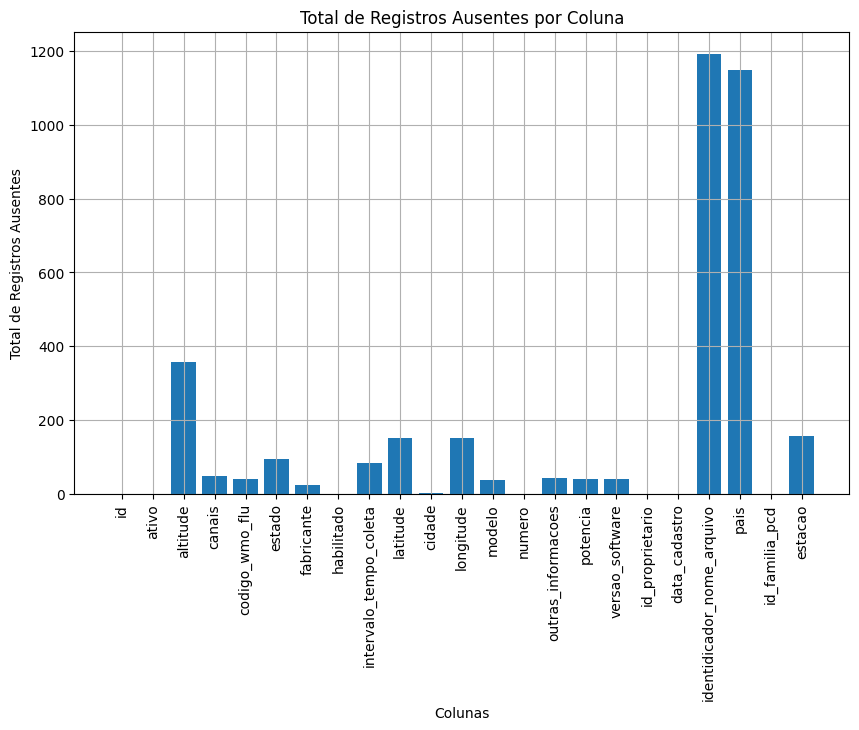

In [176]:
#visualizar graficamente a quantidade de dados ausentes te toda a tabela por coluna
plt.figure(figsize=(10, 6))
plt.bar(df_pcd.columns, df_pcd.isnull().sum())
plt.grid(True)
plt.xlabel('Colunas')
plt.ylabel('Total de Registros Ausentes')
plt.title('Total de Registros Ausentes por Coluna')
plt.xticks(rotation=90)
plt.show()


In [177]:
#preencher nome de pais da pcd baseando-se na tabela cliente pelo id do proprietario
df_pcd['pais'] = df_pcd['id_proprietario'].map(df_cliente.set_index('id')['pais'])
df_pcd_aud['pais'] = df_pcd_aud['id_proprietario'].map(df_cliente.set_index('id')['pais'])
df_pcd.head()

id  ativo     altitude canais codigo_wmo_flu estado fabricante  \
0    3166   True   667.000000      2              0     BA     HANDAR   
1    2250   True  1048.000000      1              1     DF          H   
2  141295   True         None   None           None     RN       None   
3  141557  False    52.000000   None              1     RN        BKS   
4    2288   True   586.000000      1          e2e21     PA   Squitter   

   habilitado intervalo_tempo_coleta latitude  ... numero outras_informacoes  \
0        True               10800000  -13.571  ...  32548       Meteorologia   
1        True                3600000     None  ...  30866        hidrologica   
2        True                   None   -5.487  ...  70113               None   
3        True                   None   -6.066  ...  70116               None   
4        True                3600000     None  ...  30904        Hidrologica   

  potencia  versao_software id_proprietario            data_cadastro  \
0        1            BRNM6            1015  2017-09-08 17:24:27.607   
1        1               QA            1015  2017-09-08 17:24:27.607   
2     None             None          141145  2019-06-10 14:10:13.217   
3        1             None            1080   2019-07-31 15:30:29.76   
4        1            ELNH4            1015  2017-09-08 17:24:27.607   

  identidicador_nome_arquivo    pais id_familia_pcd       estacao  
0                       None  Braisl           1997    Jaguaquara  
1                       None  Braisl           1105          None  
2                       None  Brasil             73  Maxaranguape  
3                       None  Barsil         141544  Monte Alegre  
4                       None  Braisl           1143          None  

[5 rows x 23 columns]

###Padronizando os nomes das fabricantes das PCDs

In [178]:
import pandas as pd

# Dicionário de mapeamento completo para padronização
mapeamento_fabricantes = {
    # HANDAR e variações
    'Handar': 'HANDAR',
    'handar': 'HANDAR',

    # Campbell Scientific e variações
    'Campbell': 'CAMPBELL',
    'campbell': 'CAMPBELL',
    'CAMPBELL SCIENTIFIC': 'CAMPBELL',

    # Vaisala e variações
    'Vaisala': 'VAISALA',
    'vaisala': 'VAISALA',
    'Vaisla': 'VAISALA',
    'Vaislasa': 'VAISALA',
    'VAISALA-HBU': 'VAISALA',
    'VAISALA-HB': 'VAISALA',
    'VAISALA': 'VAISALA',

    # Squitter e variações
    'Squitter': 'SQUITTER',
    'squitter': 'SQUITTER',
    'squiter': 'SQUITTER',
    'Squiter': 'SQUITTER',
    'SQITTER': 'SQUITTER',

    # Sutron e variações
    'Sutron': 'SUTRON',
    'SUTRON': 'SUTRON',

    # Microcom e variações
    'microcom': 'MICROCOM',
    'Microcom': 'MICROCOM',
    'microccon': 'MICROCOM',
    'Microm': 'MICROCOM',
    'MICROCOM': 'MICROCOM',

    # Telonics e variações
    'Telonics': 'TELONICS',
    'TELONICS': 'TELONICS',

    # Outros fabricantes
    'MetOcean': 'METOCEAN',
    'METOCEAN': 'METOCEAN',
    'Seimac': 'SEIMAC',
    'SEIMAC': 'SEIMAC',
    'Elton': 'ELTON',
    'ELTON': 'ELTON',
    'Neuron': 'NEURON',
    'NEURON': 'NEURON',
    'Elta': 'ELTA',
    'ELTA': 'ELTA',
    'hal-elta': 'HAL-ELTA',
    'HAL-ELTA': 'HAL-ELTA',
    'Davis': 'DAVIS',
    'Hobeco': 'HOBECO',
    'Ucom': 'UCOM',
    'IFRN': 'IFRN',
    'ifrn': 'IFRN',
}

# 1. Limpeza inicial
df_pcd['fabricante'] = df_pcd['fabricante'].str.strip()

# 2. Aplicar o mapeamento
df_pcd['fabricante'] = df_pcd['fabricante'].replace(mapeamento_fabricantes)

# 3. Tratar valores especiais e desconhecidos
valores_desconhecidos = ['h', 'x', 'xx', 'xxx', '**', '*', 'f', 'c', 'm', 'w', 'l', 'X', 'XX', 'XXX', 'H', '', '***', '1', 'P', 'V']
df_pcd['fabricante'] = df_pcd['fabricante'].apply(
    lambda x: 'DESCONHECIDO' if str(x).upper() in [v.upper() for v in valores_desconhecidos] else x
)

# 4. Tratar valores nulos e inválidos
df_pcd['fabricante'] = df_pcd['fabricante'].replace(['\\N', 'NONE', 'NULL', None, 'nan', 'NaN'], 'NÃO INFORMADO')

# 5. Converter tudo para maiúsculas para consistência final
df_pcd['fabricante'] = df_pcd['fabricante'].str.upper()

# 6. Verificação final
contagem_fabricantes = df_pcd['fabricante'].value_counts()
print("Contagem de fabricantes padronizados:")
print(contagem_fabricantes)


Contagem de fabricantes padronizados:
fabricante
HANDAR           591
DESCONHECIDO     217
CAMPBELL         134
VAISALA           68
SQUITTER          52
MICROCOM          28
SUTRON            25
TELONICS          23
NÃO INFORMADO     22
ELTON              7
SEIMAC             6
METOCEAN           4
ELTA               2
HAL-ELTA           2
IFRN               2
NEURON             2
BKS                1
HOBECO             1
BRNM               1
DAVIS              1
SAMANAU            1
UCOM               1
SP                 1
MI                 1
INEMAH2            1
Name: count, dtype: int64


In [179]:
#Fazendo a mesma operacao para a tabela pcd_aud
# 1. Limpeza inicial
df_pcd_aud['fabricante'] = df_pcd_aud['fabricante'].str.strip()

# 2. Aplicar o mapeamento
df_pcd_aud['fabricante'] = df_pcd_aud['fabricante'].replace(mapeamento_fabricantes)

# 3. Tratar valores especiais e desconhecidos
valores_desconhecidos = ['h', 'x', 'xx', 'xxx', '**', '*', 'f', 'c', 'm', 'w', 'l', 'X', 'XX', 'XXX', 'H', '', '***', '1', 'P', 'V']
df_pcd_aud['fabricante'] = df_pcd_aud['fabricante'].apply(
    lambda x: 'DESCONHECIDO' if str(x).upper() in [v.upper() for v in valores_desconhecidos] else x
)

# 4. Tratar valores nulos e inválidos
df_pcd_aud['fabricante'] = df_pcd_aud['fabricante'].replace(['\\N', 'NONE', 'NULL', None, 'nan', 'NaN'], 'NÃO INFORMADO')

# 5. Converter tudo para maiúsculas para consistência final
df_pcd_aud['fabricante'] = df_pcd_aud['fabricante'].str.upper()

# 6. Verificação final
contagem_fabricantes1 = df_pcd_aud['fabricante'].value_counts()
print("Contagem de fabricantes padronizados:")
print(contagem_fabricantes1)

Contagem de fabricantes padronizados:
fabricante
HANDAR           596
DESCONHECIDO     220
CAMPBELL         135
VAISALA           68
NÃO INFORMADO     57
SQUITTER          52
MICROCOM          33
SUTRON            26
TELONICS          23
ELTON              7
SEIMAC             6
METOCEAN           4
BRNM               2
ELTA               2
AGROMET            2
IFRN               2
HAL-ELTA           2
NEURON             2
DAVIS              1
BKS                1
SAMANAU            1
SP                 1
MI                 1
INEMAH2            1
HOBECO             1
UCOM               1
Name: count, dtype: int64


In [180]:

# Dicionário de mapeamento para padronização
mapeamento_informacoes = {
    # Hidrologia
    'Hidrologica': 'HIDROLOGIA',
    'hidrologica': 'HIDROLOGIA',
    'HIDROLOGICA': 'HIDROLOGIA',
    'hidrologicas': 'HIDROLOGIA',
    'Hidrologogica': 'HIDROLOGIA',
    'Hidrologgica': 'HIDROLOGIA',

    # Meteorologia
    'Meteorologica': 'METEOROLOGIA',
    'meteorologica': 'METEOROLOGIA',
    'METEOROLOGICA': 'METEOROLOGIA',
    'Meteorologico': 'METEOROLOGIA',
    'Metorologica': 'METEOROLOGIA',
    'Metoeorologica': 'METEOROLOGIA',
    'Meteorlogica': 'METEOROLOGIA',
    'Metrorologica': 'METEOROLOGIA',
    'Tipo meteorológica \nAlcoa Beneficiamento': 'METEOROLOGIA',
    'Tipo meteorológica \nAlcoa Porto': 'METEOROLOGIA',



    # Agrometeorologia
    'Agrometeorologica': 'AGROMETEOROLOGIA',
    'agrometeorologica': 'AGROMETEOROLOGIA',
    'Agrometeorologia': 'AGROMETEOROLOGIA',
    'agromet': 'AGROMETEOROLOGIA',
    'Agromet': 'AGROMETEOROLOGIA',
    'AGROMET': 'AGROMETEOROLOGIA',
    'AgroMet': 'AGROMETEOROLOGIA',
    'Agrometorologica': 'AGROMETEOROLOGIA',
    'Agrometeorologico': 'AGROMETEOROLOGIA',
    'Agrometeorlogica': 'AGROMETEOROLOGIA',
    'AGROMETEOROLOGIOCA': 'AGROMETEOROLOGIA',
    'Tipo agrometeorológica': 'AGROMETEOROLOGIA',

    # Oceanografia
    'Oceanografia': 'OCEANOGRAFIA',

    # Engenharia
    'Engenharia': 'ENGENHARIA',

    # Outros casos específicos
    'Qagua': 'QUALIDADE DA ÁGUA',
    'TESTES': 'TESTES',
    'PequisaVentos': 'PESQUISA DE VENTOS',
    'Localizacao': 'LOCALIZAÇÃO',
    'RESERVADO': 'RESERVADO',

    # Valores nulos/inválidos
    '\\N': 'NÃO INFORMADO',
    None: 'NÃO INFORMADO'
}

# 1. Limpeza inicial
df_pcd['outras_informacoes'] = df_pcd['outras_informacoes'].str.strip()

# 2. Aplicar o mapeamento
df_pcd['outras_informacoes'] = df_pcd['outras_informacoes'].replace(mapeamento_informacoes)

# 3. Converter para maiúsculas para consistência
df_pcd['outras_informacoes'] = df_pcd['outras_informacoes'].str.upper()

# 4. Tratar valores desconhecidos (opcional)
valores_desconhecidos = ['TESTE', 'TESTES', 'XYZ']  # Adicione outros conforme necessário
df_pcd['outras_informacoes'] = df_pcd['outras_informacoes'].apply(
    lambda x: 'OUTROS' if x in valores_desconhecidos else x
)

contagem_informacoes = df_pcd['outras_informacoes'].value_counts()
print("Contagem de informações padronizadas:")
print(contagem_informacoes)


Contagem de informações padronizadas:
outras_informacoes
HIDROLOGIA                                   654
METEOROLOGIA                                 240
AGROMETEOROLOGIA                             115
OCEANOGRAFIA                                  78
NÃO INFORMADO                                 41
QUALIDADE DA ÁGUA                             21
OUTROS                                        14
PESQUISA DE VENTOS                            13
LOCALIZAÇÃO                                   10
ENGENHARIA                                     3
TIPO METEOROLÓGICA \NALCOA BENEFICIAMENTO      2
TIPO METEOROLÓGICA \NALCOA PORTO               2
RESERVADO                                      1
Name: count, dtype: int64


In [181]:
# 1. Limpeza inicial
df_pcd_aud['outras_informacoes'] = df_pcd_aud['outras_informacoes'].str.strip()

# 2. Aplicar o mapeamento
df_pcd_aud['outras_informacoes'] = df_pcd_aud['outras_informacoes'].replace(mapeamento_informacoes)

# 3. Converter para maiúsculas para consistência
df_pcd_aud['outras_informacoes'] = df_pcd_aud['outras_informacoes'].str.upper()

# 4. Tratar valores desconhecidos (opcional)
valores_desconhecidos = ['TESTE', 'TESTES', 'XYZ']  # outros conforme necessário
df_pcd_aud['outras_informacoes'] = df_pcd['outras_informacoes'].apply(
    lambda x: 'OUTROS' if x in valores_desconhecidos else x
)

contagem_informacoes = df_pcd['outras_informacoes'].value_counts()
print("Contagem de informações padronizadas:")
print(contagem_informacoes)

Contagem de informações padronizadas:
outras_informacoes
HIDROLOGIA                                   654
METEOROLOGIA                                 240
AGROMETEOROLOGIA                             115
OCEANOGRAFIA                                  78
NÃO INFORMADO                                 41
QUALIDADE DA ÁGUA                             21
OUTROS                                        14
PESQUISA DE VENTOS                            13
LOCALIZAÇÃO                                   10
ENGENHARIA                                     3
TIPO METEOROLÓGICA \NALCOA BENEFICIAMENTO      2
TIPO METEOROLÓGICA \NALCOA PORTO               2
RESERVADO                                      1
Name: count, dtype: int64


In [182]:
df_pcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          1194 non-null   int32 
 1   ativo                       1194 non-null   bool  
 2   altitude                    836 non-null    object
 3   canais                      1147 non-null   object
 4   codigo_wmo_flu              1154 non-null   object
 5   estado                      1101 non-null   object
 6   fabricante                  1194 non-null   object
 7   habilitado                  1194 non-null   bool  
 8   intervalo_tempo_coleta      1111 non-null   object
 9   latitude                    1042 non-null   object
 10  cidade                      1193 non-null   object
 11  longitude                   1042 non-null   object
 12  modelo                      1158 non-null   object
 13  numero                      1194 non-null   int3

In [183]:
df_pcd['ativo'].value_counts()

ativo
True     1177
False      17
Name: count, dtype: int64

In [184]:
#listas as PCD desativadas
df_pcd[df_pcd['ativo'] == False]

id  ativo    altitude canais codigo_wmo_flu estado     fabricante  \
3     141557  False   52.000000   None              1     RN            BKS   
20    141150  False        None   None           None   None  NÃO INFORMADO   
21    141328  False    0.000000   None           None     RN          DAVIS   
40    141154  False        None   None           None     RN  NÃO INFORMADO   
41    141337  False   10.000000   None              1     RN  NÃO INFORMADO   
43    141444  False        None   None              1     RN  NÃO INFORMADO   
46    141216  False   10.000000   None           None     RN  NÃO INFORMADO   
1119      88  False  125.000000   None           None     RN       CAMPBELL   
1120      90  False   61.000000   None           None     RN       CAMPBELL   
1122      92  False   67.000000   None           None     RN       CAMPBELL   
1124      94  False  171.000000   None           None     RN       CAMPBELL   
1126      97  False  258.000000   None           None     RN       CAMPBELL   
1128      99  False   38.000000   None           None     RN       CAMPBELL   
1130     101  False   79.000000   None           None     RN       CAMPBELL   
1132     103  False  708.000000   None           None     RN       CAMPBELL   
1134     106  False    0.000000   None           None     PA  NÃO INFORMADO   
1136     108  False        None   None           None     PA  NÃO INFORMADO   

      habilitado intervalo_tempo_coleta latitude  ... numero  \
3           True                   None   -6.066  ...  70116   
20          True                   None     None  ...  80001   
21          True                   None   -6.250  ...  70114   
40          True                   None   -5.520  ...  80001   
41          True                   None   -6.250  ...  70114   
43          True                   None     None  ...  70108   
46          True                   None   -5.835  ...  70112   
1119        True                      1   -5.570  ...  70100   
1120        True                      1   -5.836  ...  70101   
1122        True                      1   -5.922  ...  70102   
1124        True                      1   -6.403  ...  70103   
1126        True                      1   -6.224  ...  70104   
1128        True                      1   -5.601  ...  70105   
1130        True                      1   -5.288  ...  70106   
1132        True                      1   -6.217  ...  70107   
1134        True                      1   -2.501  ...  70110   
1136        True                      1   -2.167  ...  70111   

                             outras_informacoes potencia  versao_software  \
3                                 NÃO INFORMADO        1             None   
20                                NÃO INFORMADO     None             None   
21                                NÃO INFORMADO     None             None   
40                                NÃO INFORMADO     None             None   
41                                NÃO INFORMADO        1             None   
43                                NÃO INFORMADO        1             None   
46                                NÃO INFORMADO     None             None   
1119                           AGROMETEOROLOGIA     None             None   
1120                           AGROMETEOROLOGIA     None             None   
1122                              NÃO INFORMADO     None             None   
1124                              NÃO INFORMADO     None             None   
1126                              NÃO INFORMADO     None             None   
1128                              NÃO INFORMADO     None             None   
1130                              NÃO INFORMADO     None             None   
1132                              NÃO INFORMADO     None             None   
1134  TIPO METEOROLÓGICA \NALCOA BENEFICIAMENTO     None             None   
1136           TIPO METEOROLÓGICA \NALCOA PORTO     None             None   

     id_proprietario            data_cadastro i

In [185]:
df_pcd_aud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          1247 non-null   int32 
 1   rev                         1247 non-null   int32 
 2   revtype                     1247 non-null   int8  
 3   ativo                       1247 non-null   bool  
 4   data_cadastro               1247 non-null   object
 5   identidicador_nome_arquivo  4 non-null      object
 6   altitude                    1208 non-null   object
 7   canais                      1162 non-null   object
 8   codigo_wmo_flu              1178 non-null   object
 9   estado                      1134 non-null   object
 10  fabricante                  1247 non-null   object
 11  habilitado                  1247 non-null   bool  
 12  intervalo_tempo_coleta      1138 non-null   object
 13  latitude                    1076 non-null   obje

In [186]:
#listar pcd desativadas
df_pcd_aud[df_pcd_aud['ativo'] == True]

id     rev  revtype  ativo            data_cadastro  \
0       3166  139944        1   True  2017-09-08 17:24:27.607   
1     139965  140031        1   True   2018-06-21 09:51:56.38   
2       2293  140704        1   True  2017-09-08 17:24:27.607   
3     141295  141296        0   True  2019-06-10 14:10:13.217   
4     141295  141297        1   True  2019-06-10 14:10:13.217   
...      ...     ...      ...    ...                      ...   
1242   39943   39944        0   True  2017-09-13 11:45:00.502   
1243   39945   39946        0   True  2017-09-13 11:45:57.343   
1244   39947   39948        0   True  2017-09-13 11:48:11.125   
1245   39949   39950        0   True  2017-09-13 11:48:53.165   
1246   82397   82398        0   True  2017-09-19 15:06:50.911   

     identidicador_nome_arquivo    altitude canais codigo_wmo_flu estado  ...  \
0                          None  667.000000      2              0     BA  ...   
1                          None  777.000000   None              2     BA  ...   
2                          None   51.000000      1              1     MA  ...   
3                          None        None   None           None     RN  ...   
4                          None        None   None           None     RN  ...   
...                         ...         ...    ...            ...    ...  ...   
1242                       None   79.000000   None           None     RN  ...   
1243                       None  708.000000   None           None     PA  ...   
1244                       None        None   None           None     PA  ...   
1245                       None        None   None           None     PA  ...   
1246                       None        None   None              1     RN  ...   

          longitude    modelo numero outras_informacoes potencia  \
0           -39.938   555BRNM  32548       METEOROLOGIA        1   
1           -45.689      None  31720         HIDROLOGIA        1   
2           -44.343  microcom  30943      NÃO INFORMADO        1   
3              None      None  70113      NÃO INFORMADO     None   
4           -35.153      None  70113         HIDROLOGIA     None   
...             ...       ...    ...                ...      ...   
1242  -36°16'31,3''   AGROMET  70106                NaN     None   
1243  -38°29'37,8''   AGROMET  70107                NaN     None   
1244  -56°10'00,5''      None  70110                NaN     None   
1245  -56°06'00,5''      None  70111                NaN     None   
1246           None      None  31050                NaN        1   

     versao_software id_proprietario        pais id_familia_pcd  \
0              BRNM6            1015      Braisl           1997   
1               None          134579      Brasil           1997   
2            labmetm            1015      Braisl           1144   
3               None          141145      Brasil             73   
4               None          141145      Brasil             73   
...              ...             ...         ...            ...   
1242            None            1038  indefinido          39895   
1243            None            1038  indefinido          39882   
1244            None             105      Brasil          39911   
1245            None             105      Brasil          39911   
1246            None            1080      Barsil          82382   

              estacao  
0          Jaguaquara  
1        Coaceral Met  
2     Itapecuru Mirim  
3                None  
4                None  
...               ...  
1242             None  
1243             None  
1244             None  
1245             None  
1246             None  

[1247 rows x 25 columns]

In [187]:
#listar as pcd que tem nome de cidade, mas nao tem latitude nem logitude
df_pcd[df_pcd['cidade'].notnull() & (df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull())]

id  ativo     altitude canais codigo_wmo_flu estado    fabricante  \
1    2250   True  1048.000000      1              1     DF  DESCONHECIDO   
4    2288   True   586.000000      1          e2e21     PA      SQUITTER   
5    2289   True    62.000000      1              1     MA  DESCONHECIDO   
6    2247   True  1048.000000      1              1     DF  DESCONHECIDO   
7    2248   True  1048.000000      1              1     DF  DESCONHECIDO   
..    ...    ...          ...    ...            ...    ...           ...   
172  3025   True     0.000000      2                  None        SUTRON   
174  2246   True  1048.000000      1              1     DF  DESCONHECIDO   
175  3081   True     0.000000      2                  None        NEURON   
176  2919   True     0.000000      2                  None  DESCONHECIDO   
177  2447   True    10.000000      1              1     SP  DESCONHECIDO   

     habilitado intervalo_tempo_coleta latitude  ... numero  \
1          True                3600000     None  ...  30866   
4          True                3600000     None  ...  30904   
5          True               10800000     None  ...  30939   
6          True                3600000     None  ...  30862   
7          True                3600000     None  ...  30864   
..          ...                    ...      ...  ...    ...   
172        True                3600000     None  ...  32407   
174        True                3600000     None  ...  30861   
175        True                   None     None  ...  32463   
176        True                   None     None  ...  32300   
177        True                3600000     None  ...  31815   

     outras_informacoes potencia  versao_software id_proprietario  \
1            HIDROLOGIA        1               QA            1015   
4            HIDROLOGIA        1            ELNH4            1015   
5          METEOROLOGIA        1             mewt            1015   
6            HIDROLOGIA        1               H1            1015   
7            HIDROLOGIA        1               H6            1015   
..                  ...      ...              ...             ...   
172  PESQUISA DE VENTOS        1            CEPEL            1015   
174          HIDROLOGIA        1               H1            1015   
175        OCEANOGRAFIA        0                             1015   
176         LOCALIZAÇÃO        0                             1015   
177        METEOROLOGIA        1          embrapa            1015   

               data_cadastro identidicador_nome_arquivo    pais  \
1    2017-09-08 17:24:27.607                       None  Braisl   
4    2017-09-08 17:24:27.607                       None  Braisl   
5    2017-09-08 17:24:27.607                       None  Braisl   
6    2017-09-08 17:24:27.607                       None  Braisl   
7    2017-09-08 17:24:27.607                       None  Braisl   
..                       ...                        ...     ...   
172  2017-09-08 17:24:27.607                       None  Braisl   
174  2017-09-08 17:24:27.607                       None  Braisl   
175  2017-09-08 17:24:27.607                       None  Braisl   
176  2017-09-08 17:24:27.607                       None  Braisl   
177  2017-09-08 17:24:27.607                       None  Braisl   

    id_familia_pcd estacao  
1             1105    None  
4             1143    None  
5             1144    None  
6             2027    None  
7             1673    None  
..             ...     ...  
172           1874    None  
174           2027    None  
175           1927    None  
176           1927    None  
177           1223    None  

[151 rows x 23 columns]

In [188]:
#visualizar apenas (cidade,estado,latitude, logitude) todas  linahs das cidades e estado que nao tem latitude nem logitude
df_pcd[['cidade', 'estado', 'latitude', 'longitude']][df_pcd['cidade'].notnull() & (df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull())]

cidade estado latitude longitude
1            TESTE-SIVAM-QA     DF     None      None
4          Barragem Tucurui     PA     None      None
5              Teste gunter     MA     None      None
6              TESTE-H1-ANA     DF     None      None
7             TEST-H6-SIVAM     DF     None      None
..                      ...    ...      ...       ...
172                CEPEL 07   None     None      None
174            TESTE-H1-ANA     DF     None      None
175   PNBOIA 01 - WMO 31961   None     None      None
176  Rastreio de Animais 10   None     None      None
177          Teste campbell     SP     None      None

[151 rows x 4 columns]

###funcao que inserire latitude e logitude no df
Essa funcao ira inserir latiude e logitude no data frame baseando-se em nome de cidade e estado a qual ela pertence.

In [189]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time
from functools import lru_cache

def preencher_coordenadas(df, user_agent="my_geocoder", timeout=10, delay=1):
    """
    Preenche latitude e longitude baseado em nomes de cidades ou lugares

    Args:
        df (pd.DataFrame): DataFrame com colunas 'cidade', 'estado', 'latitude', 'longitude'
        user_agent (str): Identificação para o serviço Nominatim
        timeout (int): Tempo máximo de espera por requisição
        delay (int): Atraso entre requisições (em segundos)

    Returns:
        pd.DataFrame: DataFrame com coordenadas preenchidas (quando encontradas)
        dict: Mapeamento dos lugares encontrados
    """
    # Verificação das colunas necessárias
    required_cols = {'cidade', 'estado', 'latitude', 'longitude'}
    if not required_cols.issubset(df.columns):
        missing = required_cols - set(df.columns)
        raise ValueError(f"Colunas faltando: {missing}")

    df_filled = df.copy()
    mapeamento = {}

    # Configuração do geocoder
    geolocator = Nominatim(user_agent=user_agent, timeout=timeout)
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=delay)

    # Função com cache e lógica de fallback
    @lru_cache(maxsize=1000)
    def buscar_coordenadas(lugar, estado=None):
        try:
            queries = []

            # Primeiro tenta com estado (se existir)
            if estado and pd.notna(estado) and estado not in ['', 'None']:
                queries.append(f"{lugar}, {estado}, Brasil")

            # Depois tenta sem estado
            queries.append(f"{lugar}, Brasil")

            # Tenta cada query até encontrar um resultado válido
            for query in queries:
                try:
                    location = geocode(query)
                    if location:
                        return (location.latitude, location.longitude)
                except:
                    continue

            return (None, None)
        except Exception as e:
            print(f"Erro ao processar {lugar}, {estado}: {str(e)}")
            return (None, None)

    # Processamento das linhas
    for idx, row in df_filled.iterrows():
        if pd.isna(row['latitude']) or pd.isna(row['longitude']):
            lugar = str(row['cidade']).strip() if pd.notna(row['cidade']) else None
            estado = str(row['estado']).strip() if pd.notna(row['estado']) else None

            if lugar and lugar not in ['', 'None']:
                lat, lon = buscar_coordenadas(lugar, estado)

                if lat and lon:
                    df_filled.at[idx, 'latitude'] = lat
                    df_filled.at[idx, 'longitude'] = lon
                    mapeamento[(lugar, estado)] = (lat, lon)

                time.sleep(delay)  # Respeita o delay entre requisições

    return df_filled, mapeamento

In [190]:
#Aplicando a função
df_pcd, mapeamento = preencher_coordenadas(df_pcd)


In [191]:
df_preechido2,mapeamento2 = preencher_coordenadas(df_pcd_aud)

In [192]:
mapeamento

{('Barragem Tucurui', 'PA'): (-3.8347147, -49.6661402),
 ('Fazenda Alegria', 'PA'): (-16.403546, -39.432463),
 ('Araras', 'PA'): (-1.4536509, -48.4763105),
 ('NATAL', 'RN'): (-5.805398, -35.2080905),
 ('Manaus', 'AM'): (-3.1316333, -59.9825041),
 ('Amontada', 'CE'): (-3.3634586, -39.8284791),
 ('BALEIA', 'CE'): (-3.1500195, -39.4395193),
 ('Cachoeira Paulista', 'SP'): (-22.6605578, -45.0081689),
 ('Braganca', 'PA'): (-1.0574255, -46.7635232),
 ('Ilha Anchieta', 'SP'): (-23.5435611, -45.0633132),
 ('Arraial do Cabo', 'RJ'): (-22.9662839, -42.024427),
 ('Nova Iguacu', 'RJ'): (-22.7592175, -43.4508728),
 ('Eldorado', 'MS'): (-23.7838809, -54.2832024),
 ('Maracaju', 'MS'): (-21.6163005, -55.164605),
 ('Jaguariaiva', 'PR'): (-24.2589699, -49.7201518),
 ('Sao Gabriel do Oeste', 'MS'): (-19.3944843, -54.5755213),
 ('Canoinhas', 'SC'): (-26.1755121, -50.3949592),
 ('Miranda', 'MS'): (-20.2401082, -56.3844728),
 ('Dourados', 'MS'): (-22.2206145, -54.812208),
 ('Faxinal', 'PR'): (-24.001212, -51

In [193]:
import plotly.express as px
import pandas as pd


# Preparação dos dados
df = pd.DataFrame([
    {
        'Estação': local[0],
        'UF': local[1] if local[1] else 'ND',
        'Latitude': coord[0],
        'Longitude': coord[1],
        'Tamanho': 10,
        'Tipo': 'Hidrológica' if 'Barragem' in local[0] else
               'Florestal' if any(x in local[0] for x in ['Floresta', 'Reserva']) else
               'Urbana' if local[1] in ['SP', 'RJ'] else
               'Rural'
    }
    for local, coord in mapeamento.items()
])

# Paleta de cores moderna
cores_tipos = {
    'Hidrológica': '#1f77b4',
    'Florestal': '#2ca02c',
    'Urbana': '#d62728',
    'Rural': '#ff7f0e'
}

# Criar o mapa
fig = px.scatter_mapbox(
    df,
    lat='Latitude',
    lon='Longitude',
    hover_name='Estação',
    hover_data={
        'UF': True,
        'Tipo': True,
        'Latitude': ':.4f',
        'Longitude': ':.4f',
        'Tamanho': False
    },
    color='Tipo',
    color_discrete_map=cores_tipos,
    size='Tamanho',
    size_max=15,
    zoom=4,
    height=800,
    width=1200,
    title='Distribuição de Estações Meteorológicas'
)

# Configuração do layout moderno
fig.update_layout(
    mapbox_style="carto-positron",  # Estilo clean
    mapbox=dict(
        center=dict(lat=-15, lon=-55),
        zoom=4.5
    ),
    margin=dict(l=20, r=20, t=80, b=40),
    plot_bgcolor='white',
    paper_bgcolor='white',
    title={
        'text': "<b>DISTRIBUIÇÃO GEOGRÁFICA DAS PCDS APÓS IMPUTAÇÃO</b><br><span style='font-size:0.9em'>Sistema integrado de Dados Ambientais - Sinda</span>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=22, family="Arial", color="#333")
    },
    hoverlabel=dict(
        bgcolor='white',
        font_size=12,
        font_family="Arial",
        bordercolor='#ccc'
    ),
    legend=dict(
        title_text='<b>Tipo de Estação</b>',
        orientation='h',
        yanchor='bottom',
        y=-0.15,
        xanchor='center',
        x=0.5,
        bgcolor='rgba(255,255,255,0.7)'
    ),
    font=dict(family="Arial", color="#333")
)

# Configuração dos marcadores (sem a propriedade 'line' que causava o erro)
fig.update_traces(
    marker=dict(
        opacity=0.9,
        sizemin=6
    ),
    selector=dict(mode='markers')
)

# Formatação do tooltip
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                 "UF: %{customdata[0]}<br>" +
                 "Tipo: %{customdata[1]}<br>" +
                 "Lat: %{customdata[2]}<br>" +
                 "Lon: %{customdata[3]}" +
                 "<extra></extra>"
)

# Rodapé
fig.add_annotation(
    text="Fonte: Dados do Sistema Meteorológico Nacional | Atualizado em 2023",
    xref="paper",
    yref="paper",
    x=0.5,
    y=-0.2,
    showarrow=False,
    font=dict(size=10, color="#777")
)

fig.show()

<ipython-input-193-7850f19243fb>:30: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [194]:
import pandas as pd
import requests
import time
from typing import Dict, Any

def preencher_altitude(df: pd.DataFrame,
                      lat_col: str = 'latitude',
                      lon_col: str = 'longitude',
                      alt_col: str = 'Altitude',
                      batch_size: int = 10,
                      max_retries: int = 3) -> pd.DataFrame:
    """
    Preenche apenas os valores faltantes de altitude no DataFrame usando coordenadas geográficas.
    Retorna o DataFrame com as altitudes preenchidas e estatísticas do processamento.

    Args:
        df: DataFrame contendo as colunas de latitude e longitude
        lat_col: Nome da coluna de latitude (padrão: 'Latitude')
        lon_col: Nome da coluna de longitude (padrão: 'Longitude')
        alt_col: Nome da coluna de altitude (padrão: 'Altitude')
        batch_size: Número máximo de coordenadas por requisição (padrão: 10)
        max_retries: Número máximo de tentativas por lote (padrão: 3)

    Returns:
        DataFrame com a coluna de altitude preenchida e estatísticas impressas
    """

    # Verificar se as colunas existem
    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError(f"DataFrame deve conter colunas '{lat_col}' e '{lon_col}'")

    # Criar cópia para não modificar o original
    df = df.copy()

    # Inicializar coluna de altitude se não existir
    if alt_col not in df.columns:
        df[alt_col] = pd.NA

    # Identificar registros com altitude faltante
    missing_mask = df[alt_col].isna()
    total_missing = missing_mask.sum()

    if total_missing == 0:
        print("Nenhuma altitude faltante para preencher.")
        return df

    print(f"Total de altitudes faltantes: {total_missing}")

    # API de elevação
    ELEVATION_API = "https://api.open-meteo.com/v1/elevation"

    # Contadores para estatísticas
    success_count = 0
    failed_count = 0
    processed_batches = 0

    # Filtrar apenas os registros com altitude faltante
    missing_df = df[missing_mask].copy()

    # Processar em lotes
    for i in range(0, len(missing_df), batch_size):
        batch = missing_df.iloc[i:i+batch_size]
        latitudes = batch[lat_col].tolist()
        longitudes = batch[lon_col].tolist()

        params = {
            "latitude": ",".join(map(str, latitudes)),
            "longitude": ",".join(map(str, longitudes))
        }

        processed_batches += 1
        elevations = []

        for attempt in range(max_retries):
            try:
                response = requests.get(ELEVATION_API, params=params, timeout=15)
                response.raise_for_status()
                data = response.json()
                elevations = data.get('elevation', [])
                break
            except Exception as e:
                print(f"Tentativa {attempt + 1} para lote {processed_batches} falhou: {str(e)}")
                if attempt == max_retries - 1:
                    print(f"Falha ao processar lote {processed_batches} após {max_retries} tentativas")
                    elevations = [pd.NA] * len(batch)
                time.sleep(2 ** attempt)  # Backoff exponencial

        # Atualizar os dados originais
        for j, (idx, row) in enumerate(batch.iterrows()):
            if j < len(elevations) and elevations[j] is not pd.NA:
                df.at[idx, alt_col] = elevations[j]
                success_count += 1
            else:
                failed_count += 1

        # Progresso
        print(f"Progresso: {min(i+batch_size, len(missing_df))}/{len(missing_df)} registros processados")
        time.sleep(1)  # Respeitar limite da API

    # Estatísticas finais
    print("\nResumo:")
    print(f"- Total de registros processados: {len(missing_df)}")
    print(f"- Altitudes obtidas com sucesso: {success_count}")
    print(f"- Falhas ao obter altitude: {failed_count}")
    print(f"- Novos registros preenchidos: {success_count/total_missing:.1%}")

    return df

In [195]:
df_pcd = preencher_altitude(df_pcd)

Total de altitudes faltantes: 1194
Tentativa 1 para lote 1 falhou: 400 Client Error: Bad Request for url: https://api.open-meteo.com/v1/elevation?latitude=-13.571%2CNone%2C-5.487%2C-6.066%2C-3.8347147%2CNone%2CNone%2CNone%2CNone%2C-3.406&longitude=-39.938%2CNone%2C-35.257%2C-35.335%2C-49.6661402%2CNone%2CNone%2CNone%2CNone%2C-44.343
Tentativa 2 para lote 1 falhou: 400 Client Error: Bad Request for url: https://api.open-meteo.com/v1/elevation?latitude=-13.571%2CNone%2C-5.487%2C-6.066%2C-3.8347147%2CNone%2CNone%2CNone%2CNone%2C-3.406&longitude=-39.938%2CNone%2C-35.257%2C-35.335%2C-49.6661402%2CNone%2CNone%2CNone%2CNone%2C-44.343
Tentativa 3 para lote 1 falhou: 400 Client Error: Bad Request for url: https://api.open-meteo.com/v1/elevation?latitude=-13.571%2CNone%2C-5.487%2C-6.066%2C-3.8347147%2CNone%2CNone%2CNone%2CNone%2C-3.406&longitude=-39.938%2CNone%2C-35.257%2C-35.335%2C-49.6661402%2CNone%2CNone%2CNone%2CNone%2C-44.343
Falha ao processar lote 1 após 3 tentativas
Progresso: 10/1194 re

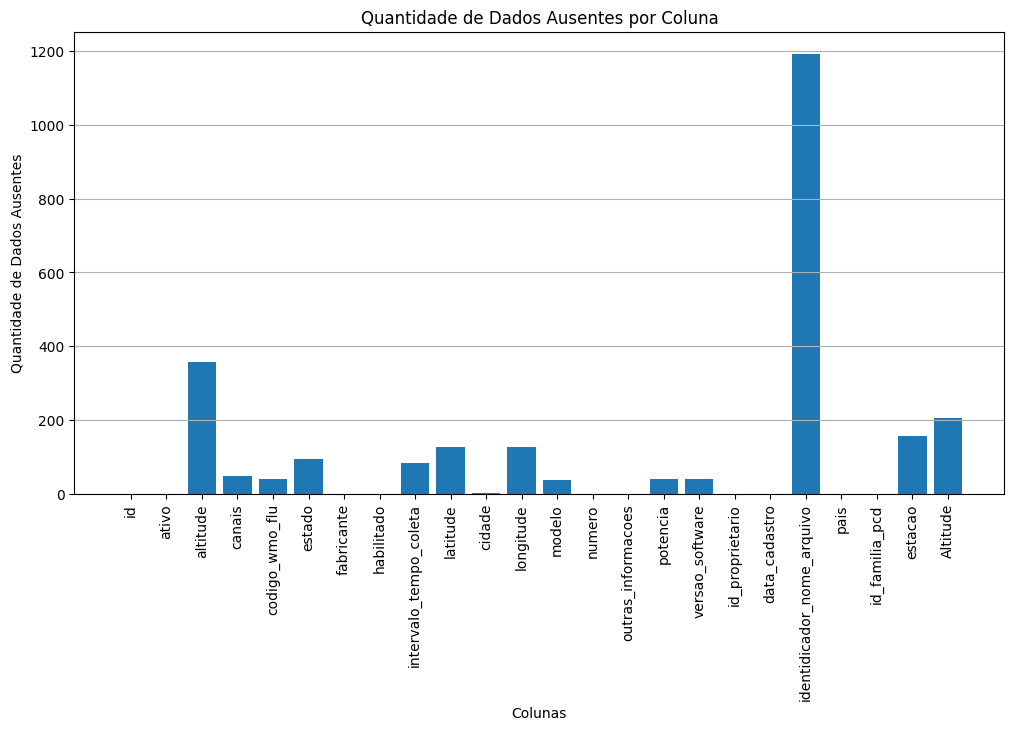

In [196]:
#visulizar graficamente dados ausentes em barras
plt.figure(figsize=(12, 6))
plt.bar(df_pcd.isnull().sum().index, df_pcd.isnull().sum())
plt.xticks(rotation=90)
plt.ylabel('Quantidade de Dados Ausentes')
plt.title('Quantidade de Dados Ausentes por Coluna')
plt.xlabel('Colunas')
plt.grid(axis='y')
plt.show()

In [197]:
#listar apenasas colunas (cidade, estado, latitute e loongitude) do df pcd quando latitude e longitude estiverem vazios
df_pcd[['cidade', 'estado', 'latitude', 'longitude']][df_pcd['latitude'].isnull() & df_pcd['longitude'].isnull()]
#mostrar total de dados 126

cidade estado latitude longitude
1            TESTE-SIVAM-QA     DF     None      None
5              Teste gunter     MA     None      None
6              TESTE-H1-ANA     DF     None      None
7             TEST-H6-SIVAM     DF     None      None
8            TESTE-H6-SIVAM     DF     None      None
..                      ...    ...      ...       ...
171   PNBOIA 08 - WMO 31967   None     None      None
174            TESTE-H1-ANA     DF     None      None
175   PNBOIA 01 - WMO 31961   None     None      None
176  Rastreio de Animais 10   None     None      None
177          Teste campbell     SP     None      None

[126 rows x 4 columns]

In [198]:
#lista de pcd sem nome de estado e com latitude e longitude vazia.
df_pcd[df_pcd['estado'].isnull() & (df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull())]


id  ativo  altitude canais codigo_wmo_flu estado     fabricante  \
20   141150  False      None   None           None   None  NÃO INFORMADO   
64     3033   True  0.000000      2                  None   DESCONHECIDO   
84     2918   True  0.000000      2                  None   DESCONHECIDO   
85     2675   True  0.000000      1              0   None   DESCONHECIDO   
86     2910   True  0.000000      2                  None   DESCONHECIDO   
..      ...    ...       ...    ...            ...    ...            ...   
169    3050   True  0.000000      2                  None       METOCEAN   
170    3051   True  0.000000      2                  None       METOCEAN   
171    3053   True  0.000000      2                  None   DESCONHECIDO   
175    3081   True  0.000000      2                  None         NEURON   
176    2919   True  0.000000      2                  None   DESCONHECIDO   

     habilitado intervalo_tempo_coleta latitude  ... outras_informacoes  \
20         True                   None     None  ...      NÃO INFORMADO   
64         True                   None     None  ...             OUTROS   
84         True                   None     None  ...        LOCALIZAÇÃO   
85         True                3600000     None  ...       OCEANOGRAFIA   
86         True                3600000     None  ...        LOCALIZAÇÃO   
..          ...                    ...      ...  ...                ...   
169        True                3600000     None  ...       OCEANOGRAFIA   
170        True                3600000     None  ...       OCEANOGRAFIA   
171        True                3600000     None  ...       OCEANOGRAFIA   
175        True                   None     None  ...       OCEANOGRAFIA   
176        True                   None     None  ...        LOCALIZAÇÃO   

    potencia versao_software  id_proprietario            data_cadastro  \
20      None            None           141145  2019-06-05 14:22:35.159   
64         1                             1015  2017-09-08 17:24:27.607   
84         0                             1015  2017-09-08 17:24:27.607   
85         1            AXYS             1015  2017-09-08 17:24:27.607   
86         0                             1015  2017-09-08 17:24:27.607   
..       ...             ...              ...                      ...   
169        0                             1015  2017-09-08 17:24:27.607   
170        0                             1015  2017-09-08 17:24:27.607   
171        1                             1015  2017-09-08 17:24:27.607   
175        0                             1015  2017-09-08 17:24:27.607   
176        0                             1015  2017-09-08 17:24:27.607   

    identidicador_nome_arquivo    pais  id_familia_pcd estacao Altitude  
20                        None  Brasil              73    None     <NA>  
64                        None  Braisl            1927    None     <NA>  
84                        None  Braisl            1927    None     <NA>  
85                        None  Braisl            1530    None     <NA>  
86                        None  Braisl            1673    None     <NA>  
..                         ...     ...             ...     ...      ...  
169                       None  Braisl            1892    None     <NA>  
170                       None  Braisl            1892    None     <NA>  
171                       None  Braisl            1892    None     <NA>  
175                       None  Braisl            1927    None     <NA>  
176                       None  Braisl            1927    None     <NA>  

[92 rows x 24 columns]

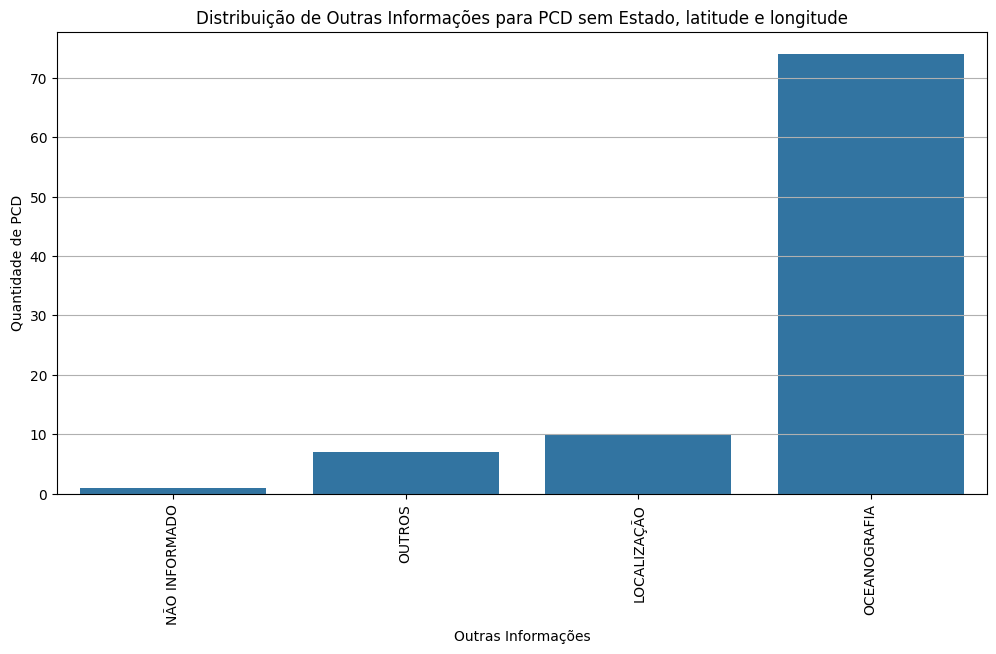

In [199]:
#vsulizar graficamente as pcd que nao tem estado, nem latitude nem logintude por outras informacoes
import matplotlib.pyplot as plt
import seaborn as sns
df_pcd_sem_estado = df_pcd[df_pcd['estado'].isnull() & (df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull())]
plt.figure(figsize=(12, 6))
sns.countplot(x='outras_informacoes', data=df_pcd_sem_estado)
plt.xticks(rotation=90)
plt.title('Distribuição de Outras Informações para PCD sem Estado, latitude e longitude')
plt.xlabel('Outras Informações')
plt.ylabel('Quantidade de PCD')
plt.grid(axis='y')
plt.show()
#

In [200]:
#total de pcds sem latitude e logintude
print(df_pcd[df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull()].shape[0])

126


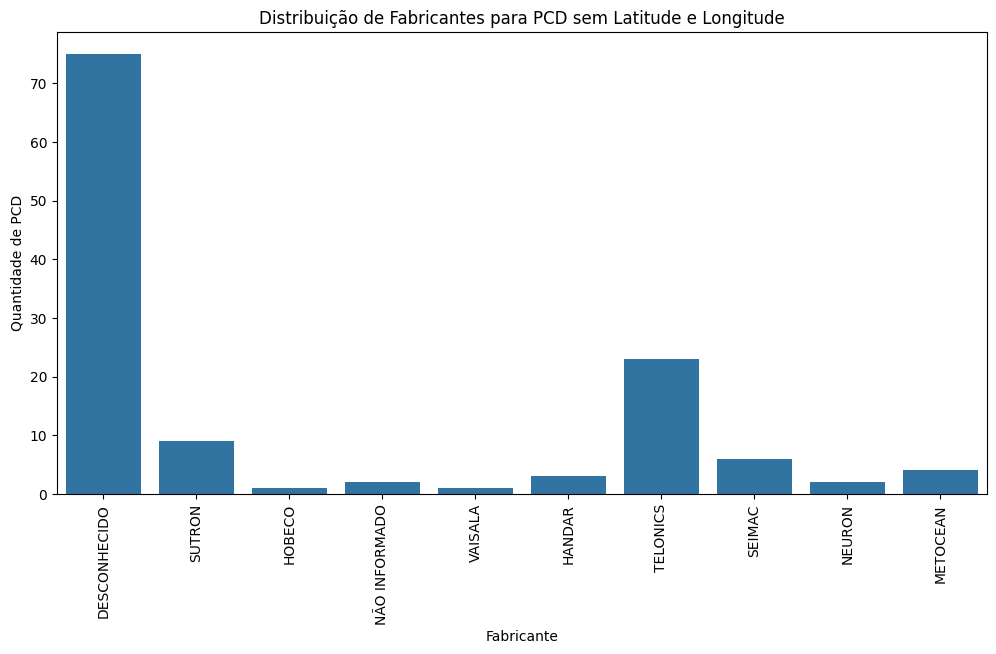

In [201]:
#visualizar graficamente pcd sem latitude e longitude por tipo de fabricante
df_pcd_sem_localizacao = df_pcd[df_pcd['latitude'].isnull() | df_pcd['longitude'].isnull()]
plt.figure(figsize=(12, 6))
sns.countplot(x='fabricante', data=df_pcd_sem_localizacao)
plt.xticks(rotation=90)
plt.title('Distribuição de Fabricantes para PCD sem Latitude e Longitude')
plt.xlabel('Fabricante')
plt.ylabel('Quantidade de PCD')
plt.show()

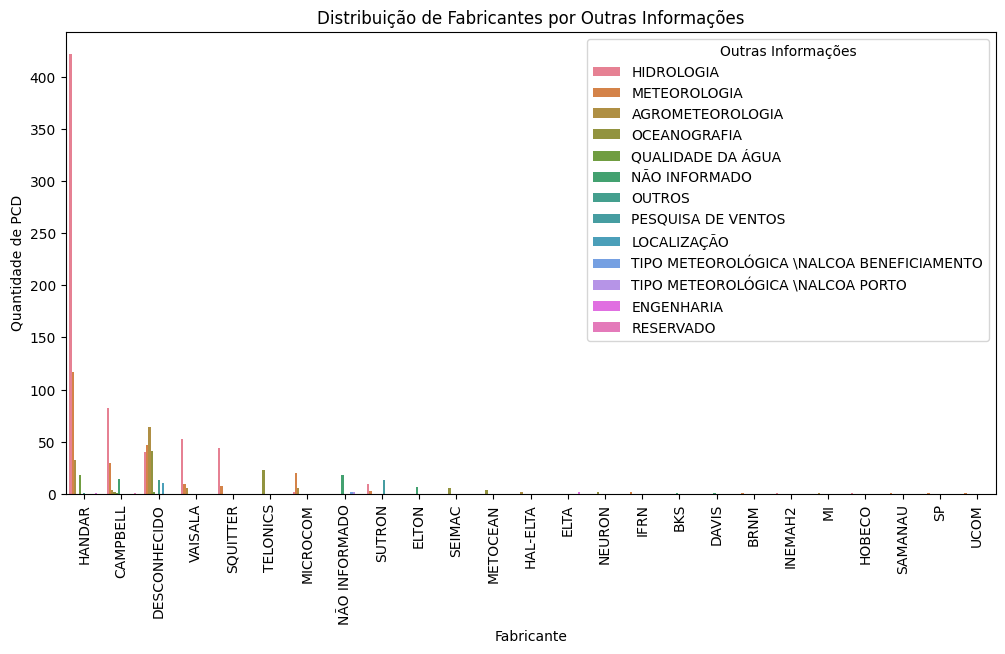

In [202]:
#associar todos tipo de fabricante com outras informacoes e visuzlizar graficamente cada fabricante com cada tipo de outras informacoes
import matplotlib.pyplot as plt
import seaborn
#ordenar do maior apra o menor a visuzlizacao
df_pcd = df_pcd.sort_values(by='fabricante', ascending=False)
df_fab_outras_info = df_pcd.groupby(['fabricante', 'outras_informacoes']).size().reset_index(name='count')
df_fab_outras_info = df_fab_outras_info.sort_values(by='count', ascending=False)
plt.figure(figsize=(12, 6))
seaborn.barplot(x='fabricante', y='count', hue='outras_informacoes', data=df_fab_outras_info)
plt.xticks(rotation=90)
plt.title('Distribuição de Fabricantes por Outras Informações')
plt.xlabel('Fabricante')
plt.ylabel('Quantidade de PCD')
plt.legend(title='Outras Informações')
plt.show()

In [203]:
df_sensor_aud = limpar_df(df_sensor_aud)
df_sensor_aud.head()

id    rev  revtype  ativo posicao     nome  equacao inicio_bits  \
0  4608  38651        1   True    None   Pluvio  +0.25*x           0   
1  5251  38651        1   True    None   Pluvio  +0.25*x          85   
2  5329  38651        1   True    None   Pluvio  +0.25*x         170   
3  6656  38651        1   True    None  UmidRel     None          12   
4  7321  38651        1   True    None  UmidRel     None          97   

  quantidade_bits shift_tempo tabela tipo_calibrador tipo_sensor  \
0              12           0   None      POLINOMIAL      PADRAO   
1              12           1   None      POLINOMIAL      PADRAO   
2              12           2   None      POLINOMIAL      PADRAO   
3               7           0   None           BRUTO      PADRAO   
4               7           1   None           BRUTO      PADRAO   

  sensor_de_data unidade_engenharia id_quadro  id_familia_pcd  virtual script  
0           None                 mm      None            1100    False   None  
1           None                 mm      None            1100    False   None  
2           None                 mm      None            1100    False   None  
3           None                  %      None            1100    False   None  
4           None                  %      None            1100    False   None

In [204]:
#visulizar todos os nomes dos sensores
df_sensor_aud['nome'].value_counts()

nome
Pluvio                  5420
Spressao                3849
UmidRel                 1542
TempAr                  1520
DirVento                1411
                        ... 
AltitudeSuperficie         1
TempSuperficie             1
WdirectionSuperficie       1
WspeedSuperficie           1
TempAr_2                   1
Name: count, Length: 352, dtype: int64

In [205]:
#visu

In [206]:
#trocar o nome estado da PCD RN\r\n para RN
df_pcd['estado'] = df_pcd['estado'].str.replace('RN\r\n', 'RN')
#trocar o estado da PCD rio de janeiro para RJ
df_pcd['estado'] = df_pcd['estado'].str.replace('Rio de Janeiro', 'RJ')

In [207]:
#PCD que tem o nome do estado Rio de Janeiro
df_pcd[df_pcd['estado'] == 'Ba']
#trocar nome Ba para BA
df_pcd['estado'] = df_pcd['estado'].str.replace('Ba', 'BA')

In [208]:
df_pcd['estado'].value_counts()

estado
SP         104
AM          99
RN          82
CE          81
PA          78
MG          64
PE          62
GO          53
MT          48
MA          47
BA          42
RO          41
TO          36
MS          28
PR          27
RS          26
SE          26
AC          24
SC          22
RR          20
AP          20
AL          19
RJ          17
Bolivia     10
DF           8
ES           6
PB           6
PI           4
RN\r\n       1
Name: count, dtype: int64

In [209]:
#selecionar Estado que tem mais 2 caracteres no nome
df_pcd[df_pcd['estado'].str.len() > 2]

id  ativo     altitude canais codigo_wmo_flu   estado fabricante  \
237   2333   True     0.000000      1              1   RN\r\n    VAISALA   
1189  3179   True         None      2                 Bolivia     HANDAR   
1188  3174   True   120.000000      2                 Bolivia     HANDAR   
1106  3172   True   150.000000      2                 Bolivia     HANDAR   
1112  3181   True  3810.000000      2              0  Bolivia     HANDAR   
1111  3178   True  4724.000000      2              0  Bolivia     HANDAR   
1110  3176   True   580.000000      2                 Bolivia     HANDAR   
1109  3175   True   120.000000      2                 Bolivia     HANDAR   
1108  3177   True  3175.000000      2              1  Bolivia     HANDAR   
1107  3173   True   350.000000      2                 Bolivia     HANDAR   
1156  3180   True         None      2              0  Bolivia     HANDAR   

      habilitado intervalo_tempo_coleta latitude  ... outras_informacoes  \
237         True                3600000   -6.643  ...         HIDROLOGIA   
1189        True               10800000  -16.822  ...       METEOROLOGIA   
1188        True                3600000  -11.104  ...         HIDROLOGIA   
1106        True                3600000  -15.888  ...         HIDROLOGIA   
1112        True               10800000  -16.204  ...       METEOROLOGIA   
1111        True               10800000  -21.492  ...       METEOROLOGIA   
1110        True                3600000  -14.438  ...         HIDROLOGIA   
1109        True                3600000  -11.104  ...         HIDROLOGIA   
1108        True                3600000  -16.553  ...         HIDROLOGIA   
1107        True                3600000  -16.971  ...         HIDROLOGIA   
1156        True               10800000  -16.971  ...       METEOROLOGIA   

     potencia versao_software  id_proprietario            data_cadastro  \
237         1              hb             1015  2017-09-08 17:24:27.607   
1189        1            BRM4             1015  2017-09-08 17:24:27.607   
1188        1                             1015  2017-09-08 17:24:27.607   
1106        1                             1015  2017-09-08 17:24:27.607   
1112        1            BRM4             1015  2017-09-08 17:24:27.607   
1111        1            BRM4             1015  2017-09-08 17:24:27.607   
1110        1                             1015  2017-09-08 17:24:27.607   
1109        1                             1015  2017-09-08 17:24:27.607   
1108        1              **             1015  2017-09-08 17:24:27.607   
1107        1                             1015  2017-09-08 17:24:27.607   
1156        1            BRM4             1015  2017-09-08 17:24:27.607   

     identidicador_nome_arquivo    pais  id_familia_pcd  \
237                        None  Braisl            1176   
1189                       None  Braisl            2042   
1188                       None  Braisl            2028   
1106                       None  Braisl            2027   
1112                       None  Braisl            2036   
1111                       None  Braisl            2042   
1110                       None  Braisl            2028   
1109                       None  Braisl            2028   
1108                       None  Braisl            2032   
1107                       None  Braisl            2028   
1156                       None  Braisl            2042   

                      estacao Altitude  
237   Santo Antonio do Sabugi    172.0  
1189        Puerto Villarroel    205.0  
1188               Miraflores    121.0  
1106                El Carmen    181.0  
1112                Huatajata   3822.0  
1111                 Caquella   5607.0  
1110             Rurrenabaque    190.0  
1109               Miraflores    121.0  
1108                 Aranjuez   3300.0  
1107             Villa Tunari    223.0  
1156             Villa Tunari    301.0  

[11 rows x 24 columns]

In [210]:
#trocar o nome do estado da  PCD com ID 2333 para RN
df_pcd.loc[df_pcd['id'] == 2333, 'estado'] = 'RN'

In [211]:
df_pcd['estado'].value_counts()

estado
SP         104
AM          99
RN          83
CE          81
PA          78
MG          64
PE          62
GO          53
MT          48
MA          47
BA          42
RO          41
TO          36
MS          28
PR          27
RS          26
SE          26
AC          24
SC          22
AP          20
RR          20
AL          19
RJ          17
Bolivia     10
DF           8
PB           6
ES           6
PI           4
Name: count, dtype: int64

In [212]:
df_pcd.head()

id  ativo    altitude canais codigo_wmo_flu estado fabricante  \
339  2438   True  546.000000      2              1     TO    VAISALA   
255  2347   True    0.000000      1              1     RN    VAISALA   
253  2345   True    0.000000      1              1     RN    VAISALA   
252  2344   True    0.000000      1              1     RN    VAISALA   
251  2343   True    0.000000      1              1     RN    VAISALA   

     habilitado intervalo_tempo_coleta latitude  ... outras_informacoes  \
339        True                3600000  -12.114  ...       METEOROLOGIA   
255        True                3600000   -5.354  ...         HIDROLOGIA   
253        True                3600000   -6.635  ...         HIDROLOGIA   
252        True                3600000   -6.726  ...         HIDROLOGIA   
251        True                3600000   -5.222  ...         HIDROLOGIA   

    potencia versao_software  id_proprietario            data_cadastro  \
339        1           NEMRH             1015  2017-09-08 17:24:27.607   
255        1              hh             1015  2017-09-08 17:24:27.607   
253        1              hh             1015  2017-09-08 17:24:27.607   
252        1              hh             1015  2017-09-08 17:24:27.607   
251        1              hh             1015  2017-09-08 17:24:27.607   

    identidicador_nome_arquivo    pais  id_familia_pcd               estacao  \
339                       None  Braisl            1292  Ponto P alta B Jesus   
255                       None  Braisl            1176        Novo Rio Punau   
253                       None  Braisl            1176               Carauba   
252                       None  Braisl            1176              Esguicho   
251                       None  Braisl            1176    Lagoa do Boqueirao   

    Altitude  
339    402.0  
255      7.0  
253    177.0  
252    222.0  
251     19.0  

[5 rows x 24 columns]

In [213]:
df_pcd['habilitado'].value_counts()

habilitado
True    1194
Name: count, dtype: int64

In [214]:
df_familia_pcd.head(20)

id  ativo                                               nome  \
0   1100   True                                              30800   
1   1105   True                             Familia - 30866, 32143   
2   1111   True        Familia - 30872, 30874, 30867, 30869, 30870   
3   1112   True                             Familia - 30873, 30871   
4   1114   True               Familia - 30875, 30876, 30877, 30878   
5   1107   True                                              30868   
6   1138   True                                              30899   
7   1139   True                                              30900   
8   1140   True                                              30901   
9   1143   True                                              30904   
10  1145   True                                              30940   
11  1165   True                                              30979   
12  1184   True                                              31030   
13  1185   True                                              31044   
14  1186   True                                              31046   
15  1122   True                             Familia - 30883, 30884   
16  1127   True  Familia - 30888, 30889, 30890, 30891, 30892, 3...   
17  1136   True  Familia - 30897, 69030, 30898, 69031, 69032, 6...   
18  1161   True  Familia - 30960, 31020, 31021, 31022, 31023, 3...   
19  1162   True                             Familia - 30975, 30976   

              data_cadastro   tipo_pcd  
0   2017-09-08 17:24:27.607  UM_QUADRO  
1   2017-09-08 17:24:27.607  UM_QUADRO  
2   2017-09-08 17:24:27.607  UM_QUADRO  
3   2017-09-08 17:24:27.607  UM_QUADRO  
4   2017-09-08 17:24:27.607  UM_QUADRO  
5   2017-09-08 17:24:27.607  UM_QUADRO  
6   2017-09-08 17:24:27.607  UM_QUADRO  
7   2017-09-08 17:24:27.607  UM_QUADRO  
8   2017-09-08 17:24:27.607  UM_QUADRO  
9   2017-09-08 17:24:27.607  UM_QUADRO  
10  2017-09-08 17:24:27.607  UM_QUADRO  
11  2017-09-08 17:24:27.607  UM_QUADRO  
12  2017-09-08 17:24:27.607  UM_QUADRO  
13  2017-09-08 17:24:27.607  UM_QUADRO  
14  2017-09-08 17:24:27.607  UM_QUADRO  
15  2017-09-08 17:24:27.607  UM_QUADRO  
16  2017-09-08 17:24:27.607  UM_QUADRO  
17  2017-09-08 17:24:27.607  UM_QUADRO  
18  2017-09-08 17:24:27.607  UM_QUADRO  
19  2017-09-08 17:24:27.607  UM_QUADRO

In [215]:
df_pcd['id_familia_pcd'].value_counts()

id_familia_pcd
2027    205
1673    191
1415     79
1799     69
1927     56
       ... 
1186      1
1100      1
2007      1
1327      1
1266      1
Name: count, Length: 127, dtype: int64

In [216]:
df_pcd['id_proprietario'].value_counts()
# o INpe tem o id 1015 na tabela clientes


id_proprietario
1015      1146
1038        16
141145      15
58           7
1080         4
105          4
142725       2
Name: count, dtype: int64

In [217]:
#cliente que tem o ID 1038
df_cliente[df_cliente['id'] == 1038]

id  ativo         cep      cidade  \
76  1038   True  indefinido  indefinido   

                           companhia_orgao departamento_secao       email  \
76  Empresa de Pesquisa Agropecuária do RN         indefinido  indefinido   

   estado         fax  logradouro    nome        pais responsavel    telefone  \
76   None  indefinido  indefinido  emparn  indefinido  indefinido  indefinido   

   id_servidor_saida_dados_decodificados  \
76                                134498   

   quantidade_dias_envio_dados_decodificados complemento  \
76                                        15        None   

   id_servidor_saida_dados_brutos quantidade_dias_envio_dados_brutos  
76                           None                                 15

In [218]:
#cliente que tem o ID 141145
df_cliente[df_cliente['id'] == 141145]

id  ativo        cep               cidade companhia_orgao  \
0  141145   True  12227-010  São José dos Campos  INPE-CRN-NATAL   

  departamento_secao email estado   fax logradouro   nome    pais  \
0              LAVAT  None     SP  None       None  Lavat  Brasil   

          responsavel telefone id_servidor_saida_dados_decodificados  \
0  Francisco Raimundo     None                                  None   

  quantidade_dias_envio_dados_decodificados complemento  \
0                                      None        None   

  id_servidor_saida_dados_brutos quantidade_dias_envio_dados_brutos  
0                           None                               None

In [219]:
#cliente que tem o id 58
df_cliente[df_cliente['id'] == 58]

id  ativo   cep cidade                  companhia_orgao  \
79  58   True  None   None  Centro de Hidrologia da Marinha   

   departamento_secao email estado   fax logradouro     nome    pais  \
79               None  None   None  None       None  dhnboia  Brasil   

   responsavel telefone id_servidor_saida_dados_decodificados  \
79        None     None                                134492   

   quantidade_dias_envio_dados_decodificados complemento  \
79                                        15        None   

   id_servidor_saida_dados_brutos quantidade_dias_envio_dados_brutos  
79                           None                               None

In [220]:
#cliente que tem o id 1080 e 58

df_cliente[df_cliente['id'] == 1080]


id  ativo        cep cidade companhia_orgao departamento_secao  \
2  1080   True  59064-000  Natal    INPE - Natal      Secao Tecnica   

                 email estado            fax                       logradouro  \
2  kennedy@crn.inpe.br     RN  (084)231-4941  Av.Senador Salgado Filho - 3000   

  nome    pais           responsavel       telefone  \
2  crn  Barsil  Kennedy Dantas Rocha  (084)231-4733   

  id_servidor_saida_dados_decodificados  \
2                                 39861   

  quantidade_dias_envio_dados_decodificados complemento  \
2                                        15        None   

  id_servidor_saida_dados_brutos quantidade_dias_envio_dados_brutos  
2                           None                                 15

In [221]:
#cliente que te o id 105
df_cliente[df_cliente['id'] == 105]

id  ativo   cep cidade                 companhia_orgao  \
78  105   True  None   None  ALCOA WORD ALUNINA BRASIL LTDA   

   departamento_secao email estado   fax logradouro   nome    pais  \
78               None  None   None  None       None  alcoa  Brasil   

   responsavel telefone id_servidor_saida_dados_decodificados  \
78        None     None                                134472   

   quantidade_dias_envio_dados_decodificados complemento  \
78                                        15        None   

   id_servidor_saida_dados_brutos quantidade_dias_envio_dados_brutos  
78                           None                               None

In [222]:
df_pcd['modelo'].value_counts()

modelo
555BRH         217
               115
CR10X           74
**              63
xx              59
              ... 
CR1000           1
CR10x            1
s                1
cr8000           1
BRNME081102      1
Name: count, Length: 111, dtype: int64

In [223]:
df_pcd['pais'].value_counts()

pais
Braisl        1146
Brasil          28
indefinido      16
Barsil           4
Name: count, dtype: int64

In [224]:
#listas estado e pais de todas as pc do estado da bolivia
df_pcd[df_pcd['estado'] == 'Bolivia']

id  ativo     altitude canais codigo_wmo_flu   estado fabricante  \
1189  3179   True         None      2                 Bolivia     HANDAR   
1188  3174   True   120.000000      2                 Bolivia     HANDAR   
1106  3172   True   150.000000      2                 Bolivia     HANDAR   
1112  3181   True  3810.000000      2              0  Bolivia     HANDAR   
1111  3178   True  4724.000000      2              0  Bolivia     HANDAR   
1110  3176   True   580.000000      2                 Bolivia     HANDAR   
1109  3175   True   120.000000      2                 Bolivia     HANDAR   
1108  3177   True  3175.000000      2              1  Bolivia     HANDAR   
1107  3173   True   350.000000      2                 Bolivia     HANDAR   
1156  3180   True         None      2              0  Bolivia     HANDAR   

      habilitado intervalo_tempo_coleta latitude  ... outras_informacoes  \
1189        True               10800000  -16.822  ...       METEOROLOGIA   
1188        True                3600000  -11.104  ...         HIDROLOGIA   
1106        True                3600000  -15.888  ...         HIDROLOGIA   
1112        True               10800000  -16.204  ...       METEOROLOGIA   
1111        True               10800000  -21.492  ...       METEOROLOGIA   
1110        True                3600000  -14.438  ...         HIDROLOGIA   
1109        True                3600000  -11.104  ...         HIDROLOGIA   
1108        True                3600000  -16.553  ...         HIDROLOGIA   
1107        True                3600000  -16.971  ...         HIDROLOGIA   
1156        True               10800000  -16.971  ...       METEOROLOGIA   

     potencia versao_software  id_proprietario            data_cadastro  \
1189        1            BRM4             1015  2017-09-08 17:24:27.607   
1188        1                             1015  2017-09-08 17:24:27.607   
1106        1                             1015  2017-09-08 17:24:27.607   
1112        1            BRM4             1015  2017-09-08 17:24:27.607   
1111        1            BRM4             1015  2017-09-08 17:24:27.607   
1110        1                             1015  2017-09-08 17:24:27.607   
1109        1                             1015  2017-09-08 17:24:27.607   
1108        1              **             1015  2017-09-08 17:24:27.607   
1107        1                             1015  2017-09-08 17:24:27.607   
1156        1            BRM4             1015  2017-09-08 17:24:27.607   

     identidicador_nome_arquivo    pais  id_familia_pcd            estacao  \
1189                       None  Braisl            2042  Puerto Villarroel   
1188                       None  Braisl            2028         Miraflores   
1106                       None  Braisl            2027          El Carmen   
1112                       None  Braisl            2036          Huatajata   
1111                       None  Braisl            2042           Caquella   
1110                       None  Braisl            2028       Rurrenabaque   
1109                       None  Braisl            2028         Miraflores   
1108                       None  Braisl            2032           Aranjuez   
1107                       None  Braisl            2028       Villa Tunari   
1156                       None  Braisl            2042       Villa Tunari   

     Altitude  
1189    205.0  
1188    121.0  
1106    181.0  
1112   3822.0  
1111   5607.0  
1110    190.0  
1109    121.0  
1108   3300.0  
1107    223.0  
1156    301.0  

[10 rows x 24 columns]

In [225]:
#Todas as pcd do estado Bolivia devem ser do pais Bolivia e trocar o nome
df_pcd.loc[df_pcd['estado'] == 'Bolivia', 'pais'] = 'Bolivia'


In [226]:
df_pcd['pais'].value_counts()

pais
Braisl        1136
Brasil          28
indefinido      16
Bolivia         10
Barsil           4
Name: count, dtype: int64

In [227]:
#PCD com nome \N devem ter o nome Brasil
df_pcd.loc[df_pcd['pais'] == '\\N', 'pais'] = 'Brasil'

In [228]:
df_pcd['pais'].value_counts()

pais
Braisl        1136
Brasil          28
indefinido      16
Bolivia         10
Barsil           4
Name: count, dtype: int64

In [229]:
df_pcd['outras_informacoes'].info()

<class 'pandas.core.series.Series'>
Index: 1194 entries, 339 to 3
Series name: outras_informacoes
Non-Null Count  Dtype 
--------------  ----- 
1194 non-null   object
dtypes: object(1)
memory usage: 18.7+ KB


In [230]:
todos_dfs.keys()

dict_keys(['df_schema_version', 'df_cliente', 'df_decodificador', 'df_estacao', 'df_evento_sistema', 'df_evento_ultima_atualizacao_dados_pcd', 'df_familia_pcd', 'df_fluxo_processamento', 'df_mapeamento_pcd_28_bits', 'df_parametro_sistema', 'df_pcd', 'df_pcd_interesse_cliente', 'df_pcd_periodo_com_dado', 'df_quadro', 'df_recuperar_senha_usuario', 'df_reprocessamento_pcd_realizado', 'df_satelite', 'df_sensor', 'df_servidor', 'df_usuario', 'df_familia_pcd_aud', 'df_parametro_sistema_aud', 'df_pcd_aud', 'df_quadro_aud', 'df_revisao_auditoria', 'df_sensor_aud'])

In [231]:
df_pcd_interesse_cliente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5501 entries, 0 to 5500
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            5501 non-null   int32
 1   ativo         5501 non-null   bool 
 2   id_cliente    5501 non-null   int32
 3   id_pcd        5501 non-null   int32
 4   dados_brutos  5501 non-null   bool 
dtypes: bool(2), int32(3)
memory usage: 75.3 KB


In [232]:
df_pcd_interesse_cliente.head()

id  ativo  id_cliente  id_pcd  dados_brutos
0  134617   True      134545    2529         False
1  134618   True      134545    2530         False
2  134619   True      134545    2532         False
3  134620   True      134545    2536         False
4  134621   True      134545    2537         False

In [233]:
df_familia_pcd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             131 non-null    int32 
 1   ativo          131 non-null    bool  
 2   nome           131 non-null    object
 3   data_cadastro  131 non-null    object
 4   tipo_pcd       131 non-null    object
dtypes: bool(1), int32(1), object(3)
memory usage: 3.8+ KB


In [234]:
df_familia_pcd.tail(20)

id  ativo                                               nome  \
111   39895   True         Família de PCDs GPRS "70102, 70106, 70103"   
112   39911   True                Família de PCDs GPRS "70110, 70111"   
113    2008   True                      Familia - 32535, 32537, 32538   
114    1826   True                                    Familia - 32352   
115    1966  False                                              32493   
116      73   True      Família de PCDs GPRS"70112,70113,70114,70121"   
117   39882   True     Família de PCDs GPRS "70100,70104,70105,70107"   
118    2027   True  Familia - 32554, 32600, 32601, 32602, 32603, 3...   
119   82382   True                                              31050   
120   94080   True                                              32539   
121    1997   True  Familia - 32524, 31873, 32531, 32477, 32478, 3...   
122  141146  False                                              80001   
123  141345   True                       Familia de PCDs GPRS "70115"   
124  141397  False                                              70115   
125  141418   True                       Familia de PCDs GPRS "70101"   
126  141437   True                              Familia teste "70108"   
127  141544   True    Familia de PCDs GPRS "'70116,70117,70118,70119"   
128  141586   True                                              70120   
129  142706  False                                    Projeto Advance   
130  142708   True                    Projeto UFMA PCDs 30847 e 30848   

               data_cadastro   tipo_pcd  
111  2017-09-13 11:07:17.953       GPRS  
112  2017-09-13 11:18:03.133       GPRS  
113  2017-09-08 17:24:27.607  UM_QUADRO  
114  2017-09-08 17:24:27.607  UM_QUADRO  
115  2017-09-08 17:24:27.607  UM_QUADRO  
116  2017-09-06 11:41:36.869       GPRS  
117  2017-09-13 10:44:01.501       GPRS  
118  2017-09-08 17:24:27.607  UM_QUADRO  
119  2017-09-19 15:04:54.285  UM_QUADRO  
120  2017-11-24 13:32:59.941  UM_QUADRO  
121  2017-09-08 17:24:27.607  UM_QUADRO  
122  2019-06-05 14:20:30.376       GPRS  
123  2019-06-13 11:40:15.085       GPRS  
124  2019-06-27 13:02:56.654       GPRS  
125  2019-07-10 14:24:02.575       GPRS  
126  2019-07-10 15:12:17.364       GPRS  
127  2019-07-31 15:27:07.233       GPRS  
128  2019-08-27 08:40:06.144       GPRS  
129  2023-02-24 16:06:57.058  UM_QUADRO  
130  2023-02-24 16:52:17.374  UM_QUADRO

In [235]:
todos_dfs.keys()

dict_keys(['df_schema_version', 'df_cliente', 'df_decodificador', 'df_estacao', 'df_evento_sistema', 'df_evento_ultima_atualizacao_dados_pcd', 'df_familia_pcd', 'df_fluxo_processamento', 'df_mapeamento_pcd_28_bits', 'df_parametro_sistema', 'df_pcd', 'df_pcd_interesse_cliente', 'df_pcd_periodo_com_dado', 'df_quadro', 'df_recuperar_senha_usuario', 'df_reprocessamento_pcd_realizado', 'df_satelite', 'df_sensor', 'df_servidor', 'df_usuario', 'df_familia_pcd_aud', 'df_parametro_sistema_aud', 'df_pcd_aud', 'df_quadro_aud', 'df_revisao_auditoria', 'df_sensor_aud'])

In [236]:
df_familia_pcd_aud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1261 non-null   int32 
 1   rev            1261 non-null   int32 
 2   revtype        1261 non-null   int8  
 3   ativo          1261 non-null   bool  
 4   data_cadastro  1261 non-null   object
 5   nome           1261 non-null   object
 6   tipo_pcd       1261 non-null   object
dtypes: bool(1), int32(2), int8(1), object(3)
memory usage: 42.0+ KB


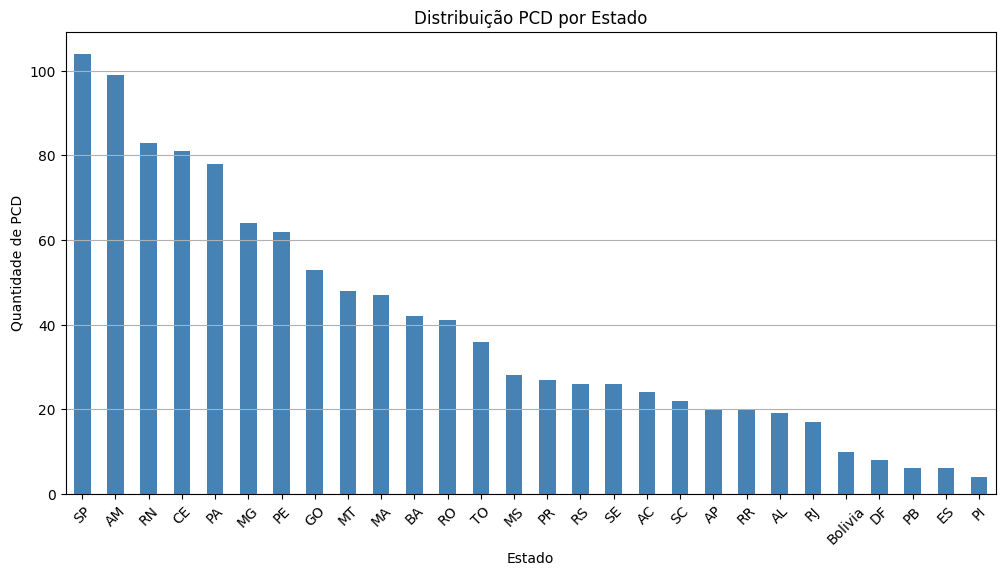

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Distribuição de estações por estado
plt.figure(figsize=(12,6))
df_pcd['estado'].value_counts().plot(kind='bar', color='steelblue')
plt.title('Distribuição PCD por Estado')
plt.xlabel('Estado')
plt.ylabel('Quantidade de PCD')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

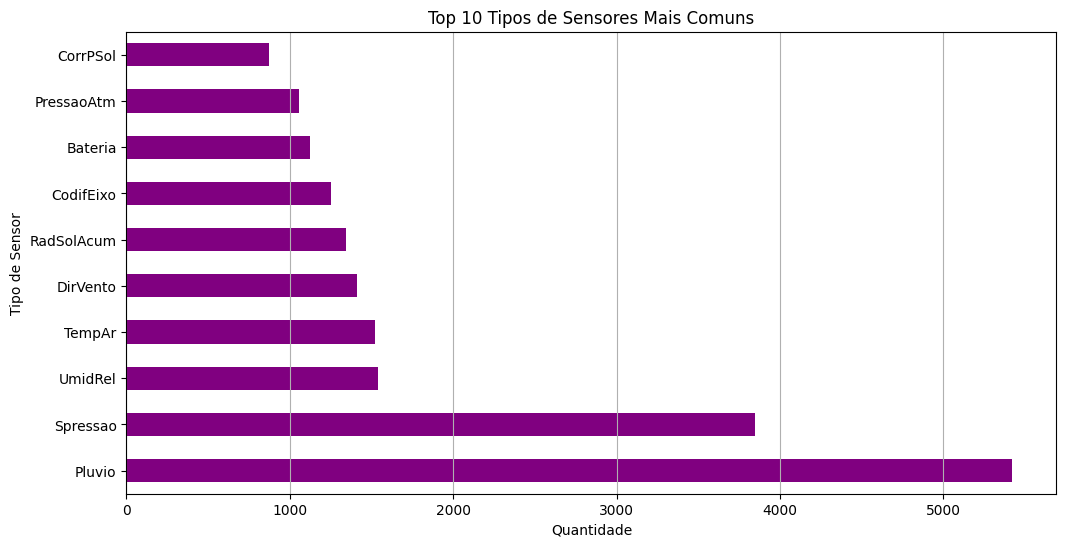

In [240]:
# Gráfico 3: Tipos de sensores mais comuns
plt.figure(figsize=(12,6))
df_sensor_aud['nome'].value_counts().head(10).plot(kind='barh', color='purple')
plt.title('Top 10 Tipos de Sensores Mais Comuns')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Sensor')
plt.grid(axis='x')
plt.show()

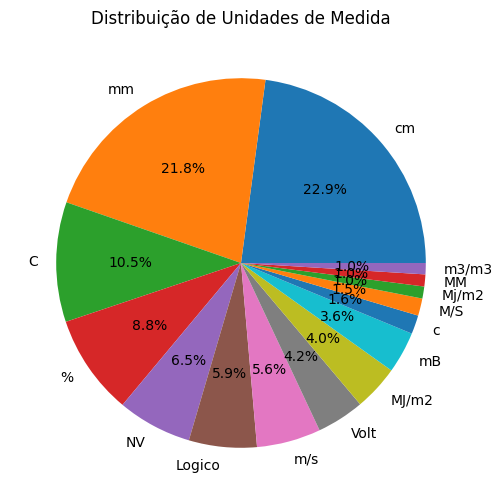

In [241]:
# Gráfico 4: Distribuição de unidades de medida
plt.figure(figsize=(12,6))
df_sensor_aud['unidade_engenharia'].value_counts().head(15).plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de Unidades de Medida')
plt.ylabel('')
plt.show()

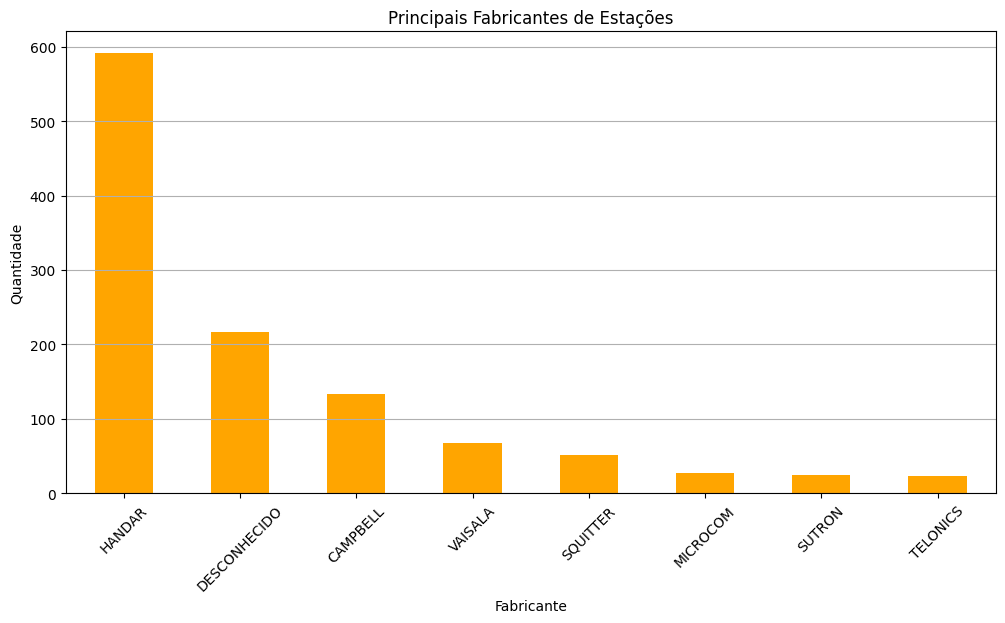

In [242]:
# Gráfico 5: Fabricantes mais comuns
plt.figure(figsize=(12,6))
df_pcd['fabricante'].value_counts().head(8).plot(kind='bar', color='orange')
plt.title('Principais Fabricantes de Estações')
plt.xlabel('Fabricante')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

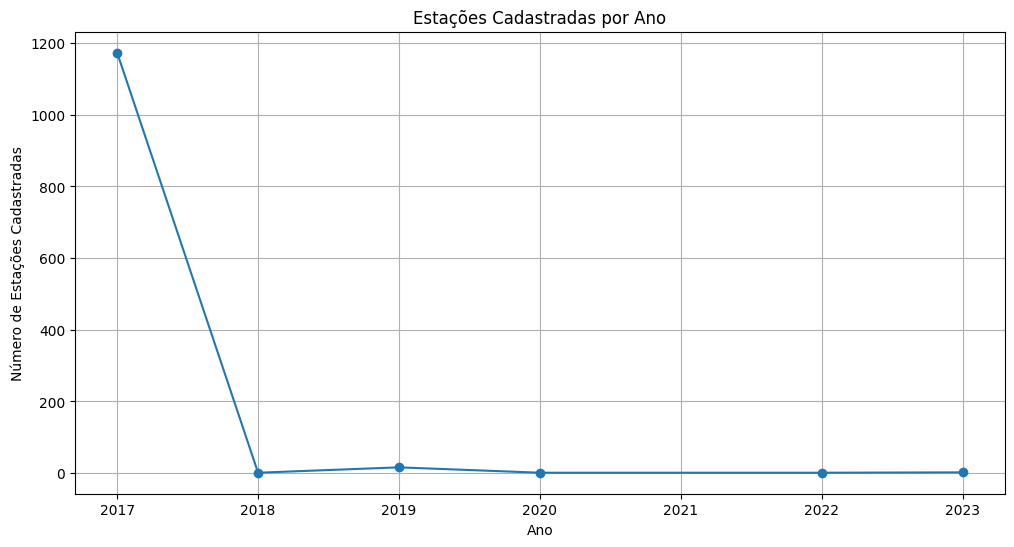

In [243]:

df_pcd['data_cadastro'] = pd.to_datetime(df_pcd['data_cadastro'])

# Gráfico 7: Estações cadastradas por ano
plt.figure(figsize=(12,6))
df_pcd['data_cadastro'].dt.year.value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Estações Cadastradas por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Estações Cadastradas')
plt.grid(True)
plt.show()

Amostra de data_inicial: ['2006-09-26 09:00:00-03', '2007-08-04 06:00:00-03', '2002-01-07 16:00:00-02']
Amostra de data_final: ['2017-07-07 15:00:00-03', '2012-10-21 06:00:00-03', '2013-10-05 06:00:00-03']

Tipos após conversão:
data_inicial    datetime64[ns, UTC]
data_final      datetime64[ns, UTC]
dtype: object

Valores inválidos:
data_inicial: 0
data_final: 0


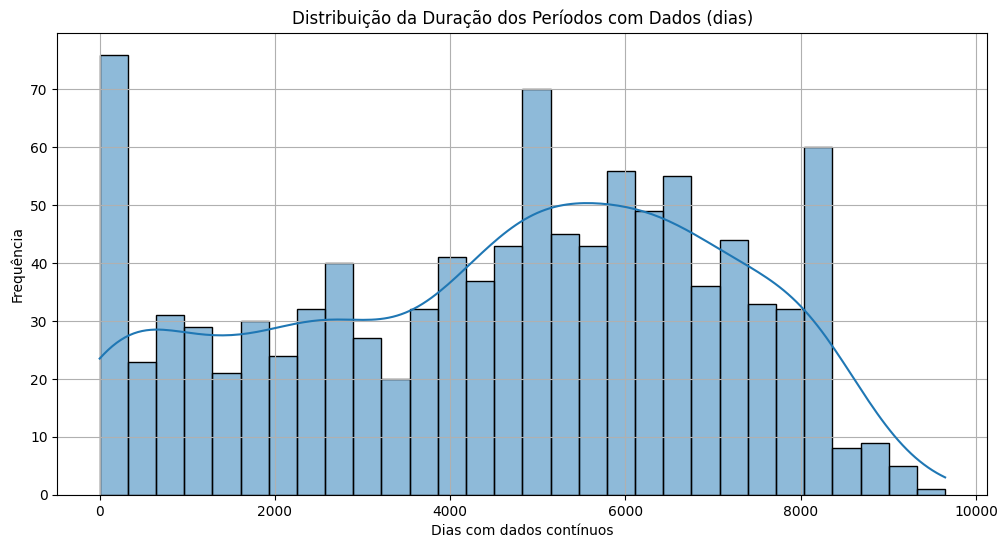

In [244]:
#dados brutos ANTES da conversão
print("Amostra de data_inicial:", df_pcd_periodo_com_dado['data_inicial'].head(3).to_list())
print("Amostra de data_final:", df_pcd_periodo_com_dado['data_final'].head(3).to_list())

# 2. Conversão robusta para datetime
def converter_data(col):
    # Primeiro tenta o parser padrão com fuso UTC
    result = pd.to_datetime(col, utc=True, errors='coerce')

    # Se muitos valores forem inválidos, tenta inferir formato
    if result.isna().mean() > 0.3:  # Se mais de 30% falharem
        result = pd.to_datetime(col, format='%d/%m/%Y', errors='coerce')

    return result

df_pcd_periodo_com_dado['data_inicial'] = converter_data(df_pcd_periodo_com_dado['data_inicial'])
df_pcd_periodo_com_dado['data_final'] = converter_data(df_pcd_periodo_com_dado['data_final'])

# 3. Verifique a conversão
print("\nTipos após conversão:")
print(df_pcd_periodo_com_dado[['data_inicial', 'data_final']].dtypes)

print("\nValores inválidos:")
print("data_inicial:", df_pcd_periodo_com_dado['data_inicial'].isna().sum())
print("data_final:", df_pcd_periodo_com_dado['data_final'].isna().sum())

# 4. Cálculo da duração (apenas para linhas válidas)
mask = df_pcd_periodo_com_dado[['data_inicial', 'data_final']].notna().all(axis=1)
df_pcd_periodo_com_dado.loc[mask, 'duracao_dias'] = (
    df_pcd_periodo_com_dado.loc[mask, 'data_final'] -
    df_pcd_periodo_com_dado.loc[mask, 'data_inicial']
).dt.days

# 5. Visualização
plt.figure(figsize=(12,6))
sns.histplot(df_pcd_periodo_com_dado['duracao_dias'].dropna(), bins=30, kde=True)
plt.title('Distribuição da Duração dos Períodos com Dados (dias)')
plt.xlabel('Dias com dados contínuos')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

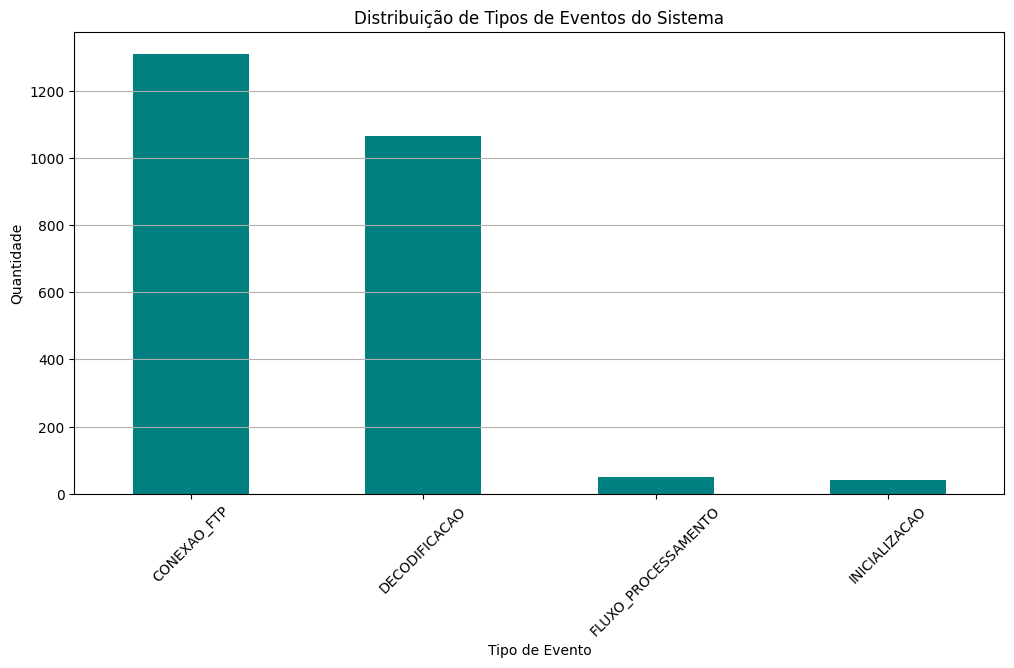

In [245]:
# Gráfico 10: Tipos de eventos do sistema
plt.figure(figsize=(12,6))
df_evento_sistema['tipo_evento_sistema'].value_counts().plot(kind='bar', color='teal')
plt.title('Distribuição de Tipos de Eventos do Sistema')
plt.xlabel('Tipo de Evento')
plt.ylabel('Quantidade')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

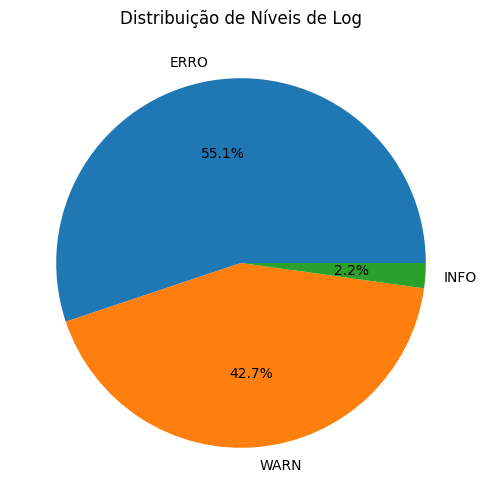

In [246]:
# Gráfico 11: Níveis de log dos eventos
plt.figure(figsize=(8,6))
df_evento_sistema['nivel_log'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição de Níveis de Log')
plt.ylabel('')
plt.show()

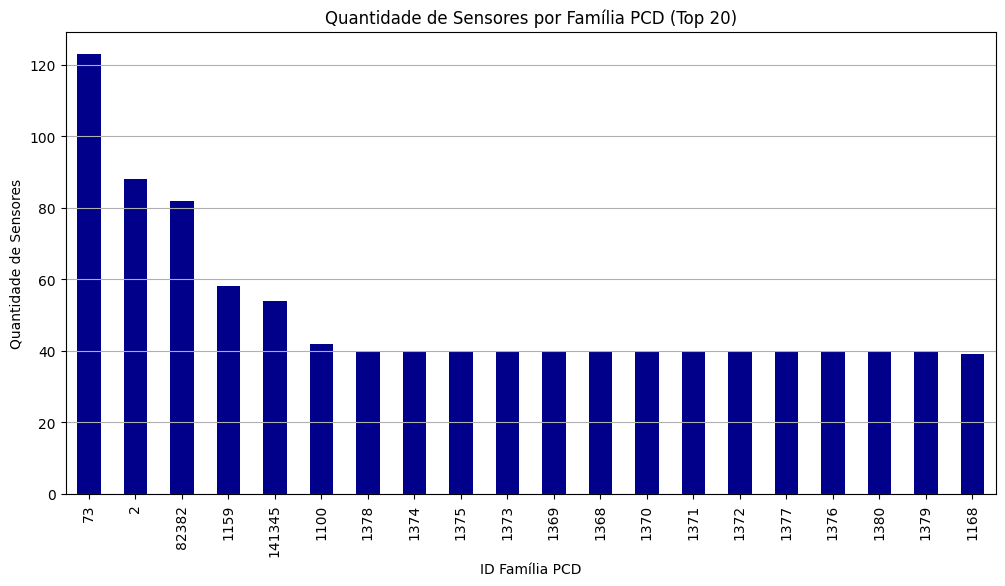

In [247]:
# Gráfico 12: Sensores por família PCD
plt.figure(figsize=(12,6))
df_sensor_aud['id_familia_pcd'].value_counts().head(20).plot(kind='bar', color='darkblue')
plt.title('Quantidade de Sensores por Família PCD (Top 20)')
plt.xlabel('ID Família PCD')
plt.ylabel('Quantidade de Sensores')
plt.grid(axis='y')
plt.show()

In [248]:
df_satelite.head()

id  ativo  codigo     nome
0  1006   True     130     SCD1
1  1007   True     131     SCD2
2  1008   True     137   CBERS2
3  1009   True     138  CBERS2B
4  1010   True     197   NOAA15

In [249]:
import geopandas as gpd
import pandas as pd
import folium
from folium.plugins import MarkerCluster, HeatMap
from shapely.geometry import Point

# Filtrar PCDs com coordenadas válidas
df_pcd = df_pcd.dropna(subset=['latitude', 'longitude'])
df_pcd['latitude'] = pd.to_numeric(df_pcd['latitude'], errors='coerce')
df_pcd['longitude'] = pd.to_numeric(df_pcd['longitude'], errors='coerce')
df_pcd = df_pcd.dropna(subset=['latitude', 'longitude'])

# Criar GeoDataFrame
geometry = [Point(xy) for xy in zip(df_pcd['longitude'], df_pcd['latitude'])]
gdf_pcd = gpd.GeoDataFrame(df_pcd, geometry=geometry, crs="EPSG:4326")

#visualizar o geodaframe

<ipython-input-249-adc3ffbccf05>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-249-adc3ffbccf05>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [265]:
import plotly.express as px
import plotly.graph_objects as go

# 1. Pré-processamento dos dados
df_pcd['categoria'] = df_pcd['outras_informacoes'].str.upper().str.strip()

# 2. Paleta de cores profissional
paleta_cores = {
    'METEOROLOGIA': '#1f77b4',
    'HIDROLOGIA': '#17becf',
    'AGROMETEOROLOGIA': '#2ca02c',
    'PESQUISA DE VENTOS': '#9467bd',
    'OCEANOGRAFIA': '#003f5c',
    'QUALIDADE DA ÁGUA': '#008080',
    'ENGENHARIA': '#ff7f0e',
    'RESERVADO': '#7f7f7f',
    'NÃO INFORMADO': '#d62728',
    'TIPO METEOROLÓGICA \\NALCOA PORTO': '#e377c2',
    'TIPO METEOROLÓGICA \\NALCOA BENEFICIAMENTO': '#bcbd22'
}

# 3. Criar o gráfico base
fig = go.Figure()

# 4. Adicionar cada categoria
for categoria, cor in paleta_cores.items():
    df_filtrado = df_pcd[df_pcd['categoria'] == categoria]
    if not df_filtrado.empty:
        fig.add_trace(go.Scattermapbox(
            lat=df_filtrado['latitude'],
            lon=df_filtrado['longitude'],
            mode='markers',
            marker=dict(size=10, color=cor, opacity=0.8),
            name=categoria,
            text=df_filtrado['estacao'],
            customdata=df_filtrado[['cidade', 'estado', 'latitude', 'longitude', 'altitude', 'categoria']],
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Cidade: %{customdata[0]}<br>"
                "Estado: %{customdata[1]}<br>"
                "Tipo: %{customdata[5]}<br>"
                "Coords: (%{customdata[2]:.4f}, %{customdata[3]:.4f})<br>"
                "Altitude: %{customdata[4]}m<extra></extra>"
            )
        ))

# 5. Configuração do layout limpo e profissional
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox=dict(center=dict(lat=-15, lon=-55), zoom=4.2),
    margin=dict(l=10, r=10, t=60, b=30),
    title={
        'text': "<b>DISTRIBUIÇÃO DAS ESTAÇÕES POR TIPO</b>",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=16, family="Arial", color="#333")  # Título menor
    },
    hoverlabel=dict(
        bgcolor='white',
        font_size=11,
        font_family="Arial"
    ),
    legend=dict(
        title_text='<b>TIPOS DE ESTAÇÕES</b>',
        orientation='h',
        yanchor='bottom',
        y=-0.15,  # Ajuste fino da posição
        xanchor='center',
        x=0.5,
        font=dict(size=9)
    )
)

# 6. Rodapé discreto
fig.add_annotation(
    text="Fonte: Sistema de Monitoramento",
    xref="paper",
    yref="paper",
    x=0.5,
    y=-0.18,  # Posição mais ajustada
    showarrow=False,
    font=dict(size=9, color="#666")  # Fonte menor e mais discreta
)

fig.show()

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

<ipython-input-265-49a6ceb7468f>:29: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. 

In [258]:
# Criar mapa com clusters
m2 = folium.Map(location=[-15, -55], zoom_start=5)

# Cluster de marcadores
marker_cluster = MarkerCluster().add_to(m2)

for idx, row in gdf_pcd.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"PCD {row['numero']}",
        icon=None
    ).add_to(marker_cluster)

# Adicionar mapa de calor
heat_data = [[row['latitude'], row['longitude']] for idx, row in gdf_pcd.iterrows()]
HeatMap(heat_data, radius=15).add_to(m2)

# Adicionar controle de camadas
folium.LayerControl().add_to(m2)

m2.save('mapa_clusters_calor.html')
m2

In [266]:
# Juntar dados de última atualização
df_pcd_atualizacao = pd.merge(df_pcd, df_evento_ultima_atualizacao_dados_pcd,
                             left_on='numero', right_on='numeropcd')

# Converter data para datetime
df_pcd_atualizacao['data_ultimo_processamento'] = pd.to_datetime(df_pcd_atualizacao['data_ultimo_processamento'])
df_pcd_atualizacao['dias_atraso'] = (pd.to_datetime('now') - df_pcd_atualizacao['data_ultimo_processamento']).dt.days

# Criar mapa
m6 = folium.Map(location=[-15, -55], zoom_start=5)

# Definir cores baseado no tempo desde a última atualização
def get_color(dias):
    if dias < 7:
        return 'green'
    elif dias < 30:
        return 'orange'
    else:
        return 'red'

for idx, row in df_pcd_atualizacao.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"""
        PCD: {row['numero']}<br>
        Última atualização: {row['data_ultimo_processamento']}<br>
        Dias atrás: {row['dias_atraso']}
        """,
        color=get_color(row['dias_atraso']),
        fill=True,
        fill_color=get_color(row['dias_atraso'])
    ).add_to(m6)

# Adicionar legenda
legend_html = '''
<div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 90px;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     ">
     <b>Última Atualização</b><br>
     <i class="fa fa-circle fa-1x" style="color:green"></i> < 7 dias<br>
     <i class="fa fa-circle fa-1x" style="color:orange"></i> 7-30 dias<br>
     <i class="fa fa-circle fa-1x" style="color:red"></i> > 30 dias
</div>
'''
m6.get_root().html.add_child(folium.Element(legend_html))

m6.save('mapa_atualizacao.html')
m6